# Models 

> Defines the main models, tools, and base classes for simulating and implementing mathematical models of circadian rhythms.

In [ ]:
#| default_exp models

In [ ]:
#| hide 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#| hide
from nbdev.showdoc import *
from fastcore.test import *
from fastcore.basics import *

In [ ]:
#| export 
import numpy as np
from abc import ABC
from typing import Tuple
from scipy.signal import find_peaks
from fastcore.basics import patch_to
from circadian.lights import LightSchedule

#| hide
# Dinamical Trajectory

#| hide
## Input checking functions

In [ ]:
#| export
#| hide
def _time_input_checking(time):
    "Checks if time is a valid input"
    if not isinstance(time, np.ndarray):
        raise TypeError("time must be a numpy array")
    if time.ndim != 1:
        raise ValueError("time must be a 1D array")
    if not np.issubdtype(time.dtype, np.number):
        raise TypeError("time must be numeric")
    if not np.all(np.diff(time) > 0):
        raise ValueError("time must be monotonically increasing")
    return True

def _state_input_checking(state, time):
    "Checks if state is a valid input"
    if not isinstance(state, np.ndarray):
        raise TypeError("states must be a numpy array")
    if state.ndim < 1:
        raise ValueError("states must have at least 1 dimension")
    if state.ndim > 3:
        raise ValueError("states must have at most 3 dimensions")
    if state.shape[0] != len(time):
        raise ValueError("states must have the same length as time")
    if not np.issubdtype(state.dtype, np.number):
        raise TypeError("states must be numeric")
    return True

#| hide
## Implementation

In [ ]:
#| export
#| hide
class DynamicalTrajectory:
    "A class to store solutions of differential equation models that contains both the time points and the states"
    def __init__(self, 
                 time: np.ndarray, # time points
                 states: np.ndarray # state at time points
                 ) -> None:
        # input checking
        _time_input_checking(time)
        _state_input_checking(states, time)
        
        self.time = time
        self.states = states
        self.num_states = states.shape[1]
        if states.ndim >= 3:
            self.batch_size = states.shape[2]
        else:
            self.batch_size = 1

In [ ]:
#| hide
# test DynamicalTrajectory's constructor
total_timepoints = 1000
variables = 2
time = np.linspace(0, 10, total_timepoints)
states = np.zeros((total_timepoints, variables))
states[:, 0] = np.sin(time)
states[:, 1] = np.cos(time)
traj = DynamicalTrajectory(time, states)
# test attributes
test_eq(traj.num_states, variables)
test_eq(traj.batch_size, 1)
test_eq(traj.time, time)
test_eq(traj.states, states)
# test batch handling
batches = 5
batch_states = np.zeros((total_timepoints, variables, batches))
batch_states[:, 0, :] = np.sin(time)[:, None]
batch_states[:, 1, :] = np.cos(time)[:, None]
batch_traj = DynamicalTrajectory(time, batch_states)
test_eq(batch_traj.num_states, variables)
test_eq(batch_traj.batch_size, batches)
test_eq(batch_traj.time, time)
test_eq(batch_traj.states, batch_states)
# test error handling
test_fail(lambda: DynamicalTrajectory(1, np.array([1, 2])), contains="time must be a numpy array")
test_fail(lambda: DynamicalTrajectory(np.array([[1, 2], [1, 2]]), np.array([1, 2]) ), contains="time must be a 1D array")
test_fail(lambda: DynamicalTrajectory(np.array(["1", "2"]), np.array([1, 2])), contains="time must be numeric")
test_fail(lambda: DynamicalTrajectory(np.array([2, 1]), np.array([1, 2])), contains="time must be monotonically increasing")
test_fail(lambda: DynamicalTrajectory(np.array([1, 2]), 1), contains="states must be a numpy array")
test_fail(lambda: DynamicalTrajectory(np.array([1, 2]), np.array(1)), contains="states must have at least 1 dimension")
test_fail(lambda: DynamicalTrajectory(np.array([1, 2]), np.zeros((1,1,1,1))), contains="states must have at most 3 dimensions")
test_fail(lambda: DynamicalTrajectory(np.array([1, 2, 3]), np.array([1, 2])), contains="states must have the same length as time")
test_fail(lambda: DynamicalTrajectory(np.array([1, 2]), np.array([1, 2, 3])), contains="states must have the same length as time")
test_fail(lambda: DynamicalTrajectory(np.array([1, 2]), np.array(["1", "2"])), contains="states must be numeric")

In [ ]:
#| export
#| hide
@patch_to(DynamicalTrajectory)
def __call__(self, timepoint: float) -> np.ndarray: # state of the system
    "Return the state at time t, linearly interpolated"
    # timepoint input checking
    if not isinstance(timepoint, (int, float)):
        raise TypeError("timepoint must be int or float")
    if timepoint < self.time[0] or timepoint > self.time[-1]:
        raise ValueError("timepoint must be within the time range")
    
    if self.batch_size == 1:
        values = np.zeros(self.num_states)
        for idx in range(self.num_states):
            values[idx] = np.interp(timepoint, self.time, self.states[..., idx])
    else:
        values = np.zeros((self.num_states, self.batch_size))
        for idx in range(self.num_states):
            for batch_idx in range(self.batch_size):
                values[idx, batch_idx] = np.interp(timepoint, self.time, self.states[..., idx, batch_idx])
    
    return values

In [ ]:
#| hide
# test DynamicalTrajectory's __call__
total_timepoints = 1000
variables = 2
time = np.linspace(0, 10, total_timepoints)
states = np.zeros((total_timepoints, variables))
states[:, 0] = np.sin(time)
states[:, 1] = np.cos(time)
traj = DynamicalTrajectory(time, states)
interpolation_error = np.abs(np.sum(traj(5.0) - (np.sin(5.0), np.cos(5.0))))
test_eq(interpolation_error < 1e-4, True)
# handle batch
batches = 5
batch_states = np.zeros((total_timepoints, variables, batches))
batch_states[:, 0, :] = np.sin(time)[:, None]
batch_states[:, 1, :] = np.cos(time)[:, None]
batch_traj = DynamicalTrajectory(time, batch_states)
interpolation_error = np.abs(np.sum((batch_traj(0.5)[0] - np.sin(0.5)) + (batch_traj(0.5)[1] - np.cos(0.5))))
test_eq(interpolation_error < 1e-4, True)
# test error handling
test_fail(lambda: traj("1"), contains="timepoint must be int or float")
test_fail(lambda: traj(11), contains="timepoint must be within the time range")

In [ ]:
#| export
#| hide
@patch_to(DynamicalTrajectory)
def __getitem__(self, time_idx: int) -> Tuple[float, np.ndarray]:
    "Return the time and state at index idx"
    # idx input checking
    if not isinstance(time_idx, int):
        raise TypeError("idx must be int")
    if time_idx < -1 or time_idx >= len(self.time):
        raise ValueError(f"idx must be within 0 and {len(self.time)-1}, got {time_idx}")
    
    return self.time[time_idx], self.states[time_idx, ...]

In [ ]:
#| hide
# test DynamicalTrajectory's __getitem__
total_timepoints = 1000
variables = 2
time = np.linspace(0, np.pi, total_timepoints)
states = np.zeros((total_timepoints, variables))
states[:, 0] = np.sin(time)
states[:, 1] = np.cos(time)
traj = DynamicalTrajectory(time, states)
test_eq(traj[0], (0.0, np.array([0.0, 1.0])))
states = traj[-1][1]
difference = np.abs(np.sum(states - (np.sin(np.pi), np.cos(np.pi))))
test_eq(difference < 1e-4, True)
# handle batch
batches = 5
batch_states = np.zeros((total_timepoints, variables, batches))
batch_states[:, 0, :] = np.sin(time)[:, None]
batch_states[:, 1, :] = np.cos(time)[:, None]
batch_traj = DynamicalTrajectory(time, batch_states)
test_eq(batch_traj[0][0], 0.0)
test_eq(np.all(batch_traj[0][1][0]==np.zeros(batches)), True)
test_eq(np.all(batch_traj[0][1][1]==np.ones(batches)), True)
# test error handling
test_fail(lambda: traj["1"], contains="idx must be int")
test_fail(lambda: traj[-2], contains="idx must be within 0 and")
test_fail(lambda: traj[1000], contains="idx must be within 0 and")

In [ ]:
#| export
#| hide
@patch_to(DynamicalTrajectory)
def __len__(self) -> int:
    return len(self.time)

In [ ]:
#| hide
# test DynamicalTrajectory's __len__
total_timepoints = 1000
variables = 2
time = np.linspace(0, np.pi, total_timepoints)
states = np.zeros((total_timepoints, variables))
states[:, 0] = np.sin(time)
states[:, 1] = np.cos(time)
traj = DynamicalTrajectory(time, states)
test_eq(len(traj), total_timepoints)
# handle batch
batches = 5
batch_states = np.zeros((total_timepoints, variables, batches))
batch_states[:, 0, :] = np.sin(time)[:, None]
batch_states[:, 1, :] = np.cos(time)[:, None]
batch_traj = DynamicalTrajectory(time, batch_states)
test_eq(len(batch_traj), total_timepoints)

In [ ]:
#| export
#| hide
@patch_to(DynamicalTrajectory)
def get_batch(self, batch_idx: int) -> 'DynamicalTrajectory':
    "Obtain the trajectory for a single batch"
    # batch_idx input checking
    if not isinstance(batch_idx, int):
        raise TypeError("batch_idx must be int")
    if batch_idx < -1 or batch_idx >= self.batch_size:
        raise ValueError(f"batch_idx must be within -1 and {self.batch_size-1}, got {batch_idx}")
    if self.states.ndim >= 3:
        return DynamicalTrajectory(self.time, self.states[:, :, batch_idx])
    else:
        # no batch dimension
        return DynamicalTrajectory(self.time, self.states)

In [ ]:
#| hide
# test DynamicalTrajectory's get_batch
total_timepoints = 1000
variables = 2
time = np.linspace(0, np.pi, total_timepoints)
states = np.zeros((total_timepoints, variables))
states[:, 0] = np.sin(time)
states[:, 1] = np.cos(time)
traj = DynamicalTrajectory(time, states)
test_eq(traj.get_batch(0).batch_size, 1)
test_eq(traj.get_batch(0).num_states, variables)
test_eq(traj.get_batch(0).time, time)
test_eq(traj.get_batch(0).states, states)
test_eq(traj.get_batch(0).states.ndim, 2)
test_eq(traj.get_batch(0).states.shape, (total_timepoints, variables))
# handle batch
batches = 5
batch_states = np.zeros((total_timepoints, variables, batches))
batch_states[:, 0, :] = np.sin(time)[:, None]
batch_states[:, 1, :] = np.cos(time)[:, None]
batch_traj = DynamicalTrajectory(time, batch_states)
test_eq(batch_traj.get_batch(0).batch_size, 1)
test_eq(batch_traj.get_batch(0).num_states, variables)
test_eq(batch_traj.get_batch(0).time, time)
test_eq(batch_traj.get_batch(0).states, batch_states[:, :, 0])
test_eq(batch_traj.get_batch(0).states.ndim, 2)
test_eq(batch_traj.get_batch(0).states.shape, (total_timepoints, variables))
test_eq(batch_traj.get_batch(4).batch_size, 1)
test_eq(batch_traj.get_batch(4).num_states, variables)
test_eq(batch_traj.get_batch(4).time, time)
test_eq(batch_traj.get_batch(4).states, batch_states[:, :, 0])
test_eq(batch_traj.get_batch(4).states.ndim, 2)
test_eq(batch_traj.get_batch(4).states.shape, (total_timepoints, variables))
test_eq(batch_traj.get_batch(-1).states, batch_traj.get_batch(4).states)
# test error handling
test_fail(lambda: traj.get_batch("1"), contains="batch_idx must be int")
test_fail(lambda: traj.get_batch(5), contains="batch_idx must be within -1 and")
test_fail(lambda: traj.get_batch(-2), contains="batch_idx must be within -1 and")

In [ ]:
#| export
#| hide
@patch_to(DynamicalTrajectory)
# String method
def __str__(self) -> str:
    time_str = np.array2string(self.time, precision=2, separator=", ", threshold=20)
    states_str = np.array2string(self.states, precision=2, separator=", ", threshold=20)
    output = f"Time:\n{time_str}\n"
    output += f"States:\n{states_str}"
    return output

#| hide
# Circadian model

#| hide
## Input checking functions

In [ ]:
#| export
#| hide
def _parameter_input_checking(parameters):
    "Checks if parameters is a valid input for a circadian model"
    if not isinstance(parameters, dict):
        raise TypeError("parameters must be a dictionary")
    if len(parameters) == 0:
        raise ValueError("parameters must not be empty")
    for key, value in parameters.items():
        if not isinstance(key, str):
            raise TypeError("keys of parameters must be strings")
        if not isinstance(value, (int, float)):
            raise TypeError("values of parameters must be numeric")
    return True


def _positive_int_checking(number, name):
    "Checks if number is a positive integer"
    if not isinstance(number, int):
        raise TypeError(f"{name} must be an integer")
    if number < 1:
        raise ValueError(f"{name} must be positive")
    return True


def _initial_condition_input_checking(initial_condition, num_states):
    "Checks if initial_condition is a valid input for a circadian model"
    if not isinstance(initial_condition, np.ndarray):
        raise TypeError("initial_condition must be a numpy array")
    if not np.issubdtype(initial_condition.dtype, np.number):
        raise TypeError("initial_condition must be numeric")
    if initial_condition.shape[0] != num_states:
        raise ValueError(f"initial_condition must have length {num_states}")
    return True


def _model_input_checking(input, num_inputs, time):
    "Checks if input has the correct shape and values for a circadian model"
    if not isinstance(input, np.ndarray):
        raise TypeError("input must be a numpy array")
    if not np.issubdtype(input.dtype, np.number):
        raise TypeError("input must be numeric")
    if input.shape[0] != len(time):
        raise ValueError(f"input's first dimension must have length {len(time)} based on the time array provided")
    if num_inputs > 1:
        if input.shape[1] != num_inputs:
            raise ValueError(f"input must have {num_inputs} columns")

    
def _light_input_checking(light):
    "Checks if light is a valid input for a circadian model"
    if not isinstance(light, np.ndarray):
        raise TypeError("light must be a numpy array")
    if light.ndim != 1:
        raise ValueError("light must be a 1D array")
    if not np.issubdtype(light.dtype, np.number):
        raise TypeError("light must be numeric")
    if not np.all(light >= 0):
        raise ValueError("light intensity must be nonnegative")
    return True


def _wake_input_checking(wake):
    "Checks if wake is a valid input for a circadian model"
    if not isinstance(wake, np.ndarray):
        raise TypeError("wake must be a numpy array")
    if wake.ndim != 1:
        raise ValueError("wake must be a 1D array")
    if not np.issubdtype(wake.dtype, np.number):
        raise TypeError("wake must be numeric")
    if not np.all(wake >= 0) and not np.all(wake <= 1):
        raise ValueError("wake must be between 0 and 1")
    return True

#| hide
## Implementation

In [ ]:
#| export
#| hide
class CircadianModel(ABC):
    "Abstract base class for circadian models that defines the common interface for all implementations"
    def __init__(self, 
                 default_params: dict, # default parameters for the model
                 num_states: int, # number of independent variables in the model
                 num_inputs: int, # number of inputs to the model such as light or wake state
                 default_initial_condition: np.ndarray # default initial conditions for the model
                 ) -> None:
        "Creates a new instance of the model"
        _parameter_input_checking(default_params)
        _positive_int_checking(num_states, "num_states")
        _positive_int_checking(num_inputs, "num_inputs")
        _initial_condition_input_checking(default_initial_condition, num_states)
        self.__default_params = default_params
        self._parameters = default_params
        for param_name, param_val in default_params.items():
            setattr(self, param_name, param_val)
        self.__num_states = num_states
        self.__num_inputs = num_inputs
        self.__default_initial_condition = default_initial_condition
        self._trajectory = None
        self._initial_condition = default_initial_condition
    
    @property
    def parameters(self) -> dict:
        return self._parameters

    @parameters.setter
    def parameters(self, value):
        for param_name, param_val in value.items():
            setattr(self, param_name, param_val)
        self._parameters = value

    @property
    def _default_params(self) -> dict:
        return self.__default_params

    @_default_params.setter
    def _default_params(self, value):
        self._parameters = value
        self.__default_params = value

    @property
    def _num_states(self) -> int: # number of independent variables in the model
        return self.__num_states

    @_num_states.setter
    def _num_states(self, value):
        self.__num_states = value

    @property
    def _num_inputs(self) -> int: # number of inputs to the model such as light or wake state
        return self.__num_inputs
    
    @_num_inputs.setter
    def _num_inputs(self, value):
        self.__num_inputs = value

    @property
    def _default_initial_condition(self) -> np.ndarray:
        return self.__default_initial_condition
    
    @_default_initial_condition.setter
    def _default_initial_condition(self, value):
        self.__default_initial_condition = value

    @property
    def trajectory(self) -> DynamicalTrajectory:
        return self._trajectory
    
    @trajectory.setter
    def trajectory(self, value):
        self._trajectory = value

    @property
    def initial_condition(self) -> np.ndarray:
        return self._initial_condition
    
    @initial_condition.setter
    def initial_condition(self, value):
        self._initial_condition = value

In [ ]:
#| hide
# test CircadianModel's constructor
default_params = {"a": 1, "b": 2}
num_states = 3
num_inputs = 2
default_initial_condition = np.array([1, 2, 3])
model = CircadianModel(default_params, num_states, num_inputs, default_initial_condition)
# test attributes
test_eq(model._default_params, default_params)
test_eq(model._num_states, num_states)
test_eq(model._num_inputs, num_inputs)
test_eq(model._default_initial_condition, default_initial_condition)
test_eq(model.parameters, default_params)
test_eq(model.initial_condition, default_initial_condition)
test_eq(model.a, 1)
test_eq(model.b, 2)
test_eq(model.trajectory, None)
# test error handling
test_fail(lambda: CircadianModel(1, num_states, num_inputs, default_initial_condition), contains="parameters must be a dictionary")
test_fail(lambda: CircadianModel({}, num_states, num_inputs, default_initial_condition), contains="parameters must not be empty")
test_fail(lambda: CircadianModel({1: 1, 2:2}, num_states, num_inputs, default_initial_condition), contains="keys of parameters must be strings")
test_fail(lambda: CircadianModel({"a": "1", "b":2}, num_states, num_inputs, default_initial_condition), contains="values of parameters must be numeric")
test_fail(lambda: CircadianModel(default_params, "1", num_inputs, default_initial_condition), contains="num_states must be an integer")
test_fail(lambda: CircadianModel(default_params, -1, num_inputs, default_initial_condition), contains="num_states must be positive")
test_fail(lambda: CircadianModel(default_params, num_states, "1", default_initial_condition), contains="num_inputs must be an integer")
test_fail(lambda: CircadianModel(default_params, num_states, -1, default_initial_condition), contains="num_inputs must be positive")
test_fail(lambda: CircadianModel(default_params, num_states, num_inputs, "1"), contains="initial_condition must be a numpy array")
test_fail(lambda: CircadianModel(default_params, num_states, num_inputs, np.array(["1", "2", "3"])), contains="initial_condition must be numeric")
test_fail(lambda: CircadianModel(default_params, num_states, num_inputs, np.array([1, 2, 3, 4])), contains="initial_condition must have length")

In [ ]:
#| export
#| hide
@patch_to(CircadianModel)
def derv(self,
         state: np.ndarray, # dynamical state of the model
         input: np.ndarray, # inputs to the model such as light or wake state
         ) -> np.ndarray:
    "Right-hand-side of the differential equation model with state and light as inputs"
    return NotImplementedError("derv is not implemented for this model")

In [ ]:
#| export
#| hide
@patch_to(CircadianModel)
def step_rk4(self,
            state: np.ndarray, # dynamical state of the model
            input: np.ndarray, # inputs to the model such as light or wake state
            dt: float, # step size in hours 
            ) -> np.ndarray:
    "Integrate the state of the model for one timestep using a fourth-order Runge-Kutta algorithm. Assumes a constant light value for the time step"
    k1 = self.derv(state, input)
    k2 = self.derv(state + k1 * dt / 2.0, input)
    k3 = self.derv(state + k2 * dt / 2.0, input)
    k4 = self.derv(state + k3 * dt, input)
    state = state + (dt / 6.0) * (k1 + 2.0*k2 + 2.0*k3 + k4)
    return state

In [ ]:
#| hide
# test CircadianModel's step_rk4
default_params = {"a": 1, "b": 2}
num_states = 3
num_inputs = 2
default_initial_condition = np.array([1, 2, 3])
model = CircadianModel(default_params, num_states, num_inputs, default_initial_condition)
model.derv = lambda state, input: np.ones_like(state)
light_input = 1.0
dt = 0.1
test_eq(np.all(model.step_rk4(default_initial_condition, light_input, dt) == np.array([1.1, 2.1, 3.1])), True)

In [ ]:
#| export
#| hide
@patch_to(CircadianModel)
def integrate(self,
              time: np.ndarray, # time points for integration. Time difference between consecutive values determines step size of the solver
              initial_condition: np.ndarray=None, # initial state of the model
              input: np.ndarray=None, # model input (such as light or wake) for each time point 
              ) -> DynamicalTrajectory:
    "Solve the model for specific timepoints given initial conditions and model inputs"
    # input checking
    _time_input_checking(time)
    if input is None:
        raise ValueError("a model input must be provided via the input argument")
    else:
        _model_input_checking(input, self._num_inputs, time)
    if initial_condition is None:
        initial_condition = self._default_initial_condition
    else:
        _initial_condition_input_checking(initial_condition, self._num_states)
    
    self.initial_condition = initial_condition
    
    n = len(time)
    sol = np.zeros((n, *initial_condition.shape))
    sol[0,...] = initial_condition
    state = initial_condition

    for idx in range(1, n):
        dt = time[idx] - time[idx-1]
        input_value = input[idx,...]
        state = self.step_rk4(state, input_value, dt)
        sol[idx,...] = state
    
    self._trajectory = DynamicalTrajectory(time, sol)
    return self._trajectory

In [ ]:
#| hide
# test integrate
default_params = {"a": 1, "b": 2}
num_states = 3
num_inputs = 2
default_initial_condition = np.array([1, 2, 3])
model = CircadianModel(default_params, num_states, num_inputs, default_initial_condition)
time = np.linspace(0, 10, 1000)
light_input = np.ones((len(time), num_inputs))
model.derv = lambda state, input: np.ones_like(state)
model.integrate(time, default_initial_condition, light_input)
test_eq(model.trajectory.num_states, num_states)
test_eq(model.trajectory.batch_size, 1)
test_eq(model.trajectory.time, time)
state_0_error = np.abs(np.sum(model.trajectory.states[:, 0] - time - 1))
state_1_error = np.abs(np.sum(model.trajectory.states[:, 1] - time - 2))
state_2_error = np.abs(np.sum(model.trajectory.states[:, 2] - time - 3))
test_eq(state_0_error < 1e-10, True)
test_eq(state_1_error < 1e-10, True)
test_eq(state_2_error < 1e-10, True)
# handle batches
batches = 5
batch_initial_conditions = np.zeros((num_states, batches))
batch_initial_conditions[:, 1] = 1
batch_initial_conditions[:, 2] = 2
batch_initial_conditions[:, 3] = 3
batch_initial_conditions[:, 4] = 4
model.integrate(time, batch_initial_conditions, light_input)
for batch in range(batches):
    batch_trajectory = model.trajectory.get_batch(batch)
    test_eq(batch_trajectory.num_states, num_states)
    test_eq(batch_trajectory.time, time)
    state_0_error = np.abs(np.sum(batch_trajectory.states[:, 0] - time - batch))
    state_1_error = np.abs(np.sum(batch_trajectory.states[:, 1] - time - batch))
    state_2_error = np.abs(np.sum(batch_trajectory.states[:, 2] - time - batch))
    test_eq(state_0_error < 1e-10, True)
    test_eq(state_1_error < 1e-10, True)
    test_eq(state_2_error < 1e-10, True)
# test error handling
test_fail(lambda: model.integrate(1, default_initial_condition, light_input), contains="time must be a numpy array")
test_fail(lambda: model.integrate(np.array([[1, 2], [1, 2]]), default_initial_condition, light_input), contains="time must be a 1D array")
test_fail(lambda: model.integrate(np.array(["1", "2"]), default_initial_condition, light_input), contains="time must be numeric")
test_fail(lambda: model.integrate(np.array([2, 1]), default_initial_condition, light_input), contains="time must be monotonically increasing")
test_fail(lambda: model.integrate(time, 1, light_input), contains="initial_condition must be a numpy array")
test_fail(lambda: model.integrate(time, np.array(["1", "2", "3"]), light_input), contains="initial_condition must be numeric")
test_fail(lambda: model.integrate(time, np.array([1, 2]), light_input), contains="initial_condition must have length")
test_fail(lambda: model.integrate(time, np.array([1, 2]), light_input[:-3]), contains="input's first dimension must have length")
test_fail(lambda: model.integrate(time, default_initial_condition, 1), contains="input must be a numpy array")
test_fail(lambda: model.integrate(time, default_initial_condition, np.array(["1", "2"])), contains="input must be numeric")
test_fail(lambda: model.integrate(time, default_initial_condition), contains="a model input must be provided via the input argument")

In [ ]:
#| export
#| hide
@patch_to(CircadianModel)
def __call__(self,
             time: np.ndarray, # time points for integration. Time difference between each consecutive pair of values determines step size of the solver
             initial_condition: np.ndarray=None, # initial state of the model
             input: np.ndarray=None, # model input (such as light or wake) for each time point
             ):
    "Wrapper to integrate"
    return self.integrate(time, initial_condition, input)

In [ ]:
#| hide
# test CircadianModel's __call__
default_params = {"a": 1, "b": 2}
num_states = 3
num_inputs = 2
default_initial_condition = np.array([1, 2, 3])
model = CircadianModel(default_params, num_states, num_inputs, default_initial_condition)
time = np.linspace(0, 10, 1000)
light_input = np.ones((len(time), num_inputs))
model.derv = lambda state, input: np.ones_like(state)
model(time, default_initial_condition, light_input)
test_eq(model.trajectory.num_states, num_states)
test_eq(model.trajectory.batch_size, 1)
test_eq(model.trajectory.time, time)
state_0_error = np.abs(np.sum(model.trajectory.states[:, 0] - time - 1))
state_1_error = np.abs(np.sum(model.trajectory.states[:, 1] - time - 2))
state_2_error = np.abs(np.sum(model.trajectory.states[:, 2] - time - 3))
test_eq(state_0_error < 1e-10, True)
test_eq(state_1_error < 1e-10, True)
test_eq(state_2_error < 1e-10, True)
# handle batches
batches = 5
batch_initial_conditions = np.zeros((num_states, batches))
batch_initial_conditions[:, 1] = 1
batch_initial_conditions[:, 2] = 2
batch_initial_conditions[:, 3] = 3
batch_initial_conditions[:, 4] = 4
model(time, batch_initial_conditions, light_input)
for batch in range(batches):
    batch_trajectory = model.trajectory.get_batch(batch)
    test_eq(batch_trajectory.num_states, num_states)
    test_eq(batch_trajectory.time, time)
    state_0_error = np.abs(np.sum(batch_trajectory.states[:, 0] - time - batch))
    state_1_error = np.abs(np.sum(batch_trajectory.states[:, 1] - time - batch))
    state_2_error = np.abs(np.sum(batch_trajectory.states[:, 2] - time - batch))
    test_eq(state_0_error < 1e-10, True)
    test_eq(state_1_error < 1e-10, True)
    test_eq(state_2_error < 1e-10, True)
# test error handling
test_fail(lambda: model(1, default_initial_condition, light_input), contains="time must be a numpy array")
test_fail(lambda: model(np.array([[1, 2], [1, 2]]), default_initial_condition, light_input), contains="time must be a 1D array")
test_fail(lambda: model(np.array(["1", "2"]), default_initial_condition, light_input), contains="time must be numeric")
test_fail(lambda: model(np.array([2, 1]), default_initial_condition, light_input), contains="time must be monotonically increasing")
test_fail(lambda: model(time, 1, light_input), contains="initial_condition must be a numpy array")
test_fail(lambda: model(time, np.array(["1", "2", "3"]), light_input), contains="initial_condition must be numeric")
test_fail(lambda: model(time, np.array([1, 2]), light_input), contains="initial_condition must have length")
test_fail(lambda: model(time, default_initial_condition, 1), contains="input must be a numpy array")
test_fail(lambda: model(time, default_initial_condition, light_input[:-3]), contains="input's first dimension must have length")
test_fail(lambda: model(time, default_initial_condition, np.array(["1", "2"])), contains="input must be numeric")
test_fail(lambda: model(time, default_initial_condition), contains="a model input must be provided via the input argument")

In [ ]:
#| export
#| hide
@patch_to(CircadianModel)
def get_parameters_array(self)-> np.array:
    "Returns the parameters for the model as a numpy array"
    parameter_array = np.zeros(len(self.parameters))
    for idx, value in enumerate(self.parameters.values()):
        parameter_array[idx] = value
    return parameter_array

In [ ]:
#| hide
# test CircadianModel's get_parameters_array
default_params = {"a": 1, "b": 2}
num_states = 3
num_inputs = 1
default_initial_conditions = np.array([1, 2, 3])
model = CircadianModel(default_params, num_states, num_inputs, default_initial_conditions)
test_eq(model.get_parameters_array(), np.array([1, 2]))

In [ ]:
#| export
#| hide
@patch_to(CircadianModel)
def phase(self,
          trajectory: DynamicalTrajectory=None, # trajectory to calculate the phase for. If None, the phase is calculated for the current trajectory 
          time: float=None # timepoint to calculate the phase at. If None, the phase is calculated for the entire trajectory
          ) -> float:
    "Calculates the phase of the model at a given timepoint"
    raise NotImplementedError("phase is not implemented for this model")

In [ ]:
#| export
#| hide
@patch_to(CircadianModel)
def amplitude(self,
              trajectory: DynamicalTrajectory=None, # trajectory to calculate the amplitude for. If None, the amplitude is calculated for the current trajectory 
              time: float=None, # timepoint to calculate the amplitude at. If None, the amplitude is calculated for the entire trajectory
              ) -> float:
    "Calculates the amplitude of the model at a given timepoint"
    raise NotImplementedError("amplitude is not implemented for this model")

In [ ]:
#| export
#| hide
@patch_to(CircadianModel)
def cbt(self,
        trajectory: DynamicalTrajectory=None, # trajectory to calculate the cbt for. If None, the cbt is calculated for the current trajectory
        ) -> np.ndarray: # array of times when the cbt occurs
    "Finds the core body temperature minumum markers along a trajectory"
    raise NotImplementedError("cbt is not implemented for this model")

In [ ]:
#| export
#| hide
@patch_to(CircadianModel)
def dlmos(self,
          trajectory: DynamicalTrajectory=None, # trajectory to calculate the dlmos for. If None, the dlmos are calculated for the current trajectory
          ) -> np.ndarray: # array of times when dlmo occurs 
    "Finds the Dim Light Melatonin Onset (DLMO) markers along a trajectory"
    raise NotImplementedError("dlmo is not implemented for this model")

In [ ]:
#| export
#| hide
@patch_to(CircadianModel)
def equilibrate(self,
                time: np.ndarray, # time points for integration. Time difference between each consecutive pair of values determines step size of the solver
                input: np.ndarray, # model input (such as light or wake) for each time point
                num_loops: int=10 # number of times to loop the input
                ) -> np.ndarray: # final state of the model
    "Equilibrate the model by looping the given light_estimate. Assumes the schedule repeats periodically after it ends"
    # input checking
    _time_input_checking(time)
    _model_input_checking(input, self._num_inputs, time)
    _positive_int_checking(num_loops, "num_loops")
    
    initial_condition = self._default_initial_condition
    for _ in range(num_loops):
        sol = self.integrate(time, initial_condition, input).states
        initial_condition = sol[-1, ...]
    final_state = sol[-1, ...]
    return final_state

In [ ]:
#| hide
# test CircadianModel's equilibrate
default_params = {"a": 1, "b": 2}
num_states = 3
num_inputs = 2
default_initial_condition = np.array([1, 2, 3])
model = CircadianModel(default_params, num_states, num_inputs, default_initial_condition)
model.derv = lambda state, input: np.ones_like(state)
time = np.linspace(0, 10, 1000)
light_input = np.ones((len(time), num_inputs))
model(time, default_initial_condition, light_input)
loops = 2
new_initial_condition = model.equilibrate(time, light_input, loops)
test_eq(new_initial_condition.shape, default_initial_condition.shape)
ground_truth = default_initial_condition + loops * time[-1]
test_eq(np.all(np.isclose(ground_truth, new_initial_condition)), True)
# test error handling
test_fail(lambda: model.equilibrate(1, light_input, loops), contains="time must be a numpy array")
test_fail(lambda: model.equilibrate(np.array([[1, 2], [1, 2]]), light_input, loops), contains="time must be a 1D array")
test_fail(lambda: model.equilibrate(np.array(["1", "2"]), light_input, loops), contains="time must be numeric")
test_fail(lambda: model.equilibrate(np.array([2, 1]), light_input, loops), contains="time must be monotonically increasing")
test_fail(lambda: model.equilibrate(time, 1, loops), contains="input must be a numpy array")
test_fail(lambda: model.equilibrate(time, np.array([[1, 2], [1, 2]]), loops), contains="input's first dimension must have length")
test_fail(lambda: model.equilibrate(time, np.array(["1", "2"]), loops), contains="input must be numeric")
test_fail(lambda: model.equilibrate(time, light_input, "1"), contains="num_loops must be an integer")
test_fail(lambda: model.equilibrate(time, light_input, -1), contains="num_loops must be positive")

#| hide
## Forger99

In [ ]:
#| export
#| hide
class Forger99(CircadianModel): 
    "Implementation of Forger's 1999 model from the article 'A simpler model of the human circadian pacemaker'"
    def __init__(self, params=None):
        default_params = {
            'taux': 24.2, 'mu': 0.23, 'G': 33.75, 
            'alpha_0': 0.05, 'beta': 0.0075, 'p': 0.50, 
            'I0': 9500.0, 'k': 0.55, 'cbt_to_dlmo': 7.0,
            }
        num_states = 3 # x, xc, n
        num_inputs = 1 # light
        default_initial_condition = np.array([-1.00982605,  0.00125715,  0.0])
        super(Forger99, self).__init__(default_params, num_states, num_inputs, default_initial_condition)
        if params is not None:
            self.parameters = params

    def integrate(self,
                  time: np.ndarray, # time points for integration. Time difference between each consecutive pair of values determines step size of the solver
                  initial_condition: np.ndarray=None, # initial state of the model
                  input: np.ndarray=None, # model input (such as light or wake) for each time point
                  ) -> DynamicalTrajectory:
        "Solve the model for specific timepoints given initial conditions and model inputs"
        # input checking for Forger99
        if input is not None:
            _light_input_checking(input)
        return super().integrate(time, initial_condition, input)

    def __repr__(self) -> str:
        return self.__str__()
    
    def __str__(self) -> str:
        return "Forger99"

In [ ]:
#| hide
# test Forger99's constructor
model = Forger99()
# test attributes
true_default_params = {
    'taux': 24.2, 'mu': 0.23, 'G': 33.75,
    'alpha_0': 0.05, 'beta': 0.0075, 'p': 0.50,
    'I0': 9500.0, 'k': 0.55, 'cbt_to_dlmo': 7.0}
test_eq(model._default_params, true_default_params)
true_initial_condition = np.array([-1.00982605,  0.00125715,  0.0])
test_eq(model._default_initial_condition, true_initial_condition)
test_eq(model.parameters, true_default_params)
test_eq(model._num_states, 3)
test_eq(model._num_inputs, 1)
for key, value in true_default_params.items():
    test_eq(getattr(model, key), value)
# test initialization with custom parameters
custom_params = {
    'taux': 1.0, 'mu': 2.0, 'G': 3.0,
    'alpha_0': 4.0, 'beta': 5.0, 'p': 6.0,
    'I0': 7.0, 'k': 8.0, 'cbt_to_dlmo': 9.0}
model = Forger99(custom_params)
# test attributes
test_eq(model._default_params, true_default_params)
test_eq(model._default_initial_condition, true_initial_condition)
test_eq(model.parameters, custom_params)
test_eq(model._num_states, 3)
test_eq(model._num_inputs, 1)
for key, value in custom_params.items():
    test_eq(getattr(model, key), value)

In [ ]:
#| hide
# test Forger99's integrate input handling
model = Forger99()
time = np.array([0, 1, 2])
light_input = np.ones(len(time))
test_fail(lambda: model.integrate(time, input="1"), contains="light must be a numpy array")
test_fail(lambda: model.integrate(time, input=np.ones((1,1))), contains="light must be a 1D")
test_fail(lambda: model.integrate(time, input=np.array(["1", "2"])), contains="light must be numeric")
test_fail(lambda: model.integrate(time, input=-light_input), contains="light intensity must be nonnegative")

In [ ]:
#| export
#| hide
@patch_to(Forger99)
def derv(self, 
         state: np.ndarray, # dynamical state (x, xc, n)
         input: float # light intensity in lux
         ) -> np.ndarray: # derivative of the state
     "Right-hand-side of the differential equation model"
     x = state[0,...]
     xc = state[1,...]
     n = state[2,...]
     light = input

     alpha = self.alpha_0 * pow((light / self.I0), self.p)
     Bhat = self.G * (1.0 - n) * alpha * (1 - 0.4 * x) * (1 - 0.4 * xc)
     mu_term = self.mu * (xc - 4.0 / 3.0 * pow(xc, 3.0))
     taux_term = pow(24.0 / (0.99669 * self.taux), 2.0) + self.k * Bhat

     dydt = np.zeros_like(state)
     dydt[0,...] = np.pi / 12.0 * (xc + Bhat)
     dydt[1,...] = np.pi / 12.0 * (mu_term - x * taux_term)
     dydt[2,...] = 60.0 * (alpha * (1.0 - n) - self.beta * n)

     return dydt

In [ ]:
#| hide
# test Forger99's derv
model = Forger99()
# single batch
state = np.array([-0.3, -1.13, 0.0])
light = 1.0
derv_error = np.abs(np.sum(model.derv(state, light) - np.array([-0.28846216, 0.1267787, 0.03077935])))
test_eq(derv_error < 1e-8, True)
# multiple batches
batches = 5
batch_states = np.zeros((3, batches))
for batch in range(batches):
    batch_states[:, batch] = state
batch_derv = model.derv(batch_states, light)
for batch in range(batches):
    derv_error = np.abs(np.sum(batch_derv[:, batch] - np.array([-0.28846216, 0.1267787, 0.03077935])))
    test_eq(derv_error < 1e-8, True)

In [ ]:
#| export
#| hide
@patch_to(Forger99)
def phase(self,
          trajectory: DynamicalTrajectory=None, # trajectory to calculate the phase. If None, the current trajectory is used
          time: float=None # a time point to calculate the phase at. If None, the phase is calculated for the entire trajectory
          ) -> float:
    if trajectory is None:
        trajectory = self.trajectory
    else: 
        if not isinstance(trajectory, DynamicalTrajectory):
            raise ValueError("trajectory must be a DynamicalTrajectory")
    if time is None:
        x = trajectory.states[:, 0]
        y = -1.0 * trajectory.states[:, 1]
    else:
        if not isinstance(time, (float, int)):
            raise ValueError("time must be a float or an int")
        else:
            state = trajectory(time)
            x = state[0] 
            y = -1.0 * state[1]
    return np.angle(x + complex(0,1) * y)

In [ ]:
#| hide
# test Forger99's phase
model = Forger99()
time = np.linspace(0, 96, 1000)
light = np.zeros_like(time)
model(time, input=light)
phase_array = np.zeros_like(time)
for idx, t in enumerate(time):
    phase_array[idx] = model.phase(time=t)
true_phase = np.angle(model.trajectory.states[:,0] + complex(0,1)*(-1.0 * model.trajectory.states[:,1]))
test_eq(np.all(np.isclose(phase_array, true_phase)), True)
# test passing the trajectory
light = LightSchedule.Regular()(time)
trajectory = model(time, input=light)
phase_array = np.zeros_like(time)
for idx, t in enumerate(time):
    phase_array[idx] = model.phase(trajectory, t)
true_phase = np.angle(model.trajectory.states[:,0] + complex(0,1)*(-1.0 * model.trajectory.states[:,1]))
test_eq(np.all(np.isclose(phase_array, true_phase)), True)
# test calculation for all trajectory
phase = model.phase()
test_eq(np.all(np.isclose(phase, true_phase)), True)
# test error handling
test_fail(lambda: model.phase(1), contains="trajectory must be a DynamicalTrajectory")
test_fail(lambda: model.phase(trajectory, "1"), contains="time must be a float or an int")

In [ ]:
#| export
#| hide
@patch_to(Forger99)
def amplitude(self,
              trajectory: DynamicalTrajectory=None, # trajectory to calculate the amplitude. If None, the current trajectory is used
              time: float=None # a time point to calculate the amplitude at. If None, the amplitude is calculated for the entire trajectory
              ) -> float:
    if trajectory is None:
        trajectory = self.trajectory
    else: 
        if not isinstance(trajectory, DynamicalTrajectory):
            raise ValueError("trajectory must be a DynamicalTrajectory")
    if time is None:
        x = trajectory.states[:, 0]
        y = -1.0 * trajectory.states[:, 1]
    else:
        if not isinstance(time, (float, int)):
            raise ValueError("time must be a float or an int")
        else:
            state = trajectory(time)
            x = state[0] 
            y = -1.0 * state[1]
    return np.sqrt(x**2 + y**2)

In [ ]:
#| hide
# test Forger99's amplitude
model = Forger99()
time = np.linspace(0, 96, 1000)
light = np.zeros_like(time)
model(time, input=light)
amplitude_array = np.zeros_like(time)
for idx, t in enumerate(time):
    amplitude_array[idx] = model.amplitude(time=t)
true_amplitude = np.sqrt(model.trajectory.states[:,0] ** 2 + model.trajectory.states[:,1] ** 2)
test_eq(np.all(np.isclose(amplitude_array, true_amplitude)), True)
# test passing the trajectory
light = LightSchedule.Regular()(time)
trajectory = model(time, input=light)
amplitude_array = np.zeros_like(time)
for idx, t in enumerate(time):
    amplitude_array[idx] = model.amplitude(trajectory, t)
true_amplitude = np.sqrt(model.trajectory.states[:,0] ** 2 + model.trajectory.states[:,1] ** 2)
test_eq(np.all(np.isclose(amplitude_array, true_amplitude)), True)
# test calculation for all trajectory
amplitude = model.amplitude()
test_eq(np.all(np.isclose(amplitude, true_amplitude)), True)
# test error handling
test_fail(lambda: model.amplitude(1), contains="trajectory must be a DynamicalTrajectory")
test_fail(lambda: model.amplitude(trajectory, "1"), contains="time must be a float or an int")

In [ ]:
#| export
#| hide
@patch_to(Forger99)
def cbt(self,
        trajectory: DynamicalTrajectory=None, # trajectory to calculate the cbt. If None, the current trajectory is used
        ) -> np.ndarray:
    "Finds the core body temperature minumum markers for the model along a trajectory as the minimum of x"
    if trajectory is None:
        trajectory = self.trajectory
    else:
        if not isinstance(trajectory, DynamicalTrajectory):
            raise ValueError("trajectory must be a DynamicalTrajectory")
    inverted_x = -1*trajectory.states[:,0]
    cbt_min_idxs, _ = find_peaks(inverted_x)
    return trajectory.time[cbt_min_idxs]

In [ ]:
#| hide
# test Forger99's cbt
model = Forger99()
time = np.linspace(0, 96, 2000)
light = np.zeros_like(time)
trajectory = model(time, input=light)
cbt_min_idxs = find_peaks(-1*trajectory.states[:,0])[0]
troughs = time[cbt_min_idxs]
test_eq(np.all(np.isclose(model.cbt(), troughs)), True)
# test passing the trajectory
light = LightSchedule.Regular()(time)
trajectory = model(time, input=light)
cbt_min_idxs = find_peaks(-1*trajectory.states[:,0])[0]
troughs = time[cbt_min_idxs]
test_eq(np.all(np.isclose(model.cbt(trajectory), troughs)), True)
# test error handling
test_fail(lambda: model.cbt(1), contains="trajectory must be a DynamicalTrajectory")

In [ ]:
#| export
#| hide
@patch_to(Forger99)
def dlmos(self,
          trajectory: DynamicalTrajectory=None, # trajectory to calculate the dlmo. If None, the current trajectory is used 
          ) -> np.ndarray:
    "Finds the Dim Light Melatonin Onset (DLMO) markers for the model along a trajectory"
    if trajectory is None:
        trajectory = self.trajectory
    else:
        if not isinstance(trajectory, DynamicalTrajectory):
            raise ValueError("trajectory must be a DynamicalTrajectory")
    return self.cbt(trajectory) - self.cbt_to_dlmo

In [ ]:
#| hide
# test Forger99's dlmos
model = Forger99()
time = np.linspace(0, 96, 2000)
light = np.zeros_like(time)
trajectory = model(time, input=light)
cbt_min_idxs = find_peaks(-1*trajectory.states[:,0])[0]
dlmos = time[cbt_min_idxs] - 7.0
test_eq(np.all(np.isclose(model.dlmos(), dlmos)), True)
# test passing the trajectory
light = LightSchedule.Regular()(time)
trajectory = model(time, input=light)
cbt_min_idxs = find_peaks(-1*trajectory.states[:,0])[0]
dlmos = time[cbt_min_idxs] - 7.0
test_eq(np.all(np.isclose(model.dlmos(trajectory), dlmos)), True)
# test error handling
test_fail(lambda: model.dlmos(1), contains="trajectory must be a DynamicalTrajectory")

In [ ]:
#| hide
# test that Forger99 can be entrained to a regular 24 hour light schedule for different initial conditions - Scientific test
days = 80
dt = 0.5
time = np.arange(0, 24*days, dt)
regular_schedule = LightSchedule.Regular()
light_values = regular_schedule(time)
# explore a broad space of initial conditions
amplitude_ic = np.linspace(1e-3, 1.0, 20)
phase_ic = np.linspace(-np.pi, np.pi, 20)
# convert amplitude and phase to x and xc
ic_stack = np.dstack(np.meshgrid(amplitude_ic, phase_ic)).reshape(-1, 2)
ic_stack = np.hstack((ic_stack, np.zeros((ic_stack.shape[0], 1))))
ic_x = np.sqrt(ic_stack[:, 0]) * np.cos(ic_stack[:, 1])
ic_xc = np.sqrt(ic_stack[:, 0]) * np.sin(ic_stack[:, 1])
initial_conditions = np.hstack((ic_x.reshape(-1, 1), ic_xc.reshape(-1, 1), np.zeros((ic_x.shape[0], 1))))
# transpose initial conditions
initial_conditions = initial_conditions.T
# simulate
model = Forger99()
result = model(time, initial_conditions, light_values)
# compare last ten days
t_comparison_idx = int(24 * 70 / dt)
reference_x = result.states[t_comparison_idx:, 0, 0]
reference_xc = result.states[t_comparison_idx:, 1, 0]
diff_x = result.states[t_comparison_idx:, 0, :].T - reference_x
diff_xc = result.states[t_comparison_idx:, 1, :].T - reference_xc
test_eq(np.all(np.isclose(diff_x, 0.0, atol=1e-2)), True)
test_eq(np.all(np.isclose(diff_xc, 0.0, atol=1e-2)), True)

#| hide
## Hannay19

In [ ]:
#| export
#| hide
class Hannay19(CircadianModel):
    "Implementation of Hannay's 2019 single population model from the article 'Macroscopic models for human circadian rhythms'"
    def __init__(self, params=None):
        default_params = {
            'tau': 23.84, 'K': 0.06358, 'gamma': 0.024, 
            'Beta1': -0.09318, 'A1': 0.3855, 'A2': 0.1977, 
            'BetaL1': -0.0026, 'BetaL2': -0.957756, 'sigma': 0.0400692, 
            'G': 33.75, 'alpha_0': 0.05, 'delta': 0.0075, 'p': 1.5, 'I0': 9325.0,
            'cbt_to_dlmo': 7.0}
        num_states = 3 # R, Psi, n
        num_inputs = 1 # light
        default_initial_condition = np.array([0.70120406, 2.32206690, 0.0])
        super(Hannay19, self).__init__(default_params, num_states, num_inputs, default_initial_condition)
        if params is not None:
            self.parameters = params

    def integrate(self,
                time: np.ndarray, # time points for integration. Time difference between each consecutive pair of values determines step size of the solver
                initial_condition: np.ndarray=None, # initial state of the model
                input: np.ndarray=None, # model input (such as light or wake) for each time point
                ) -> DynamicalTrajectory:
        "Solve the model for specific timepoints given initial conditions and model inputs"
        # input checking for Hannay19
        if input is not None:
            _light_input_checking(input)
        return super().integrate(time, initial_condition, input)

    def __repr__(self) -> str:
        return self.__str__()
    
    def __str__(self) -> str:
        return "Hannay19"

In [ ]:
#| hide
# test Hannay19's constructor
model = Hannay19()
# test attributes
true_default_params = {
    'tau': 23.84, 'K': 0.06358, 'gamma': 0.024,
    'Beta1': -0.09318, 'A1': 0.3855, 'A2': 0.1977,
    'BetaL1': -0.0026, 'BetaL2': -0.957756, 'sigma': 0.0400692,
    'G': 33.75, 'alpha_0': 0.05, 'delta': 0.0075, 'p': 1.5, 'I0': 9325.0,
    'cbt_to_dlmo': 7.0}
test_eq(model._default_params, true_default_params)
true_initial_condition = np.array([0.70120406, 2.32206690, 0.0])
test_eq(model._default_initial_condition, true_initial_condition)
test_eq(model.parameters, true_default_params)
test_eq(model._num_states, 3)
test_eq(model._num_inputs, 1)
for key, value in true_default_params.items():
    test_eq(getattr(model, key), value)
# test initialization with custom parameters
custom_params = {
    'tau': 1.0, 'K': 2.0, 'gamma': 3.0,
    'Beta1': 4.0, 'A1': 5.0, 'A2': 6.0,
    'BetaL1': 7.0, 'BetaL2': 8.0, 'sigma': 9.0,
    'G': 10.0, 'alpha_0': 11.0, 'delta': 12.0, 'p': 13.0, 'I0': 14.0,
    'cbt_to_dlmo': 15.0}
model = Hannay19(custom_params)
# test attributes
test_eq(model._default_params, true_default_params)
test_eq(model._default_initial_condition, true_initial_condition)
test_eq(model.parameters, custom_params)
test_eq(model._num_states, 3)
test_eq(model._num_inputs, 1)
for key, value in custom_params.items():
    test_eq(getattr(model, key), value)

In [ ]:
#| hide
# test Hannay19's integrate input handling
model = Hannay19()
time = np.array([0, 1, 2])
light_input = np.ones(len(time))
test_fail(lambda: model.integrate(time, input="1"), contains="light must be a numpy array")
test_fail(lambda: model.integrate(time, input=np.ones((1,1))), contains="light must be a 1D")
test_fail(lambda: model.integrate(time, input=np.array(["1", "2"])), contains="light must be numeric")
test_fail(lambda: model.integrate(time, input=-light_input), contains="light intensity must be nonnegative")

In [ ]:
#| export
#| hide
@patch_to(Hannay19)
def derv(self,
         state: np.ndarray, # dynamical state (R, Psi, n)
         input: float # light intensity in lux
         ) -> np.ndarray: # derivative of the state
    "Right-hand-side of the differential equation model"
    R = state[0,...]
    Psi = state[1,...]
    n = state[2,...]
    light = input   

    alpha = self.alpha_0 * pow(light, self.p) / (pow(light, self.p) + self.I0)

    Bhat = self.G * (1.0 - n) * alpha
    A1_term_amp = self.A1 * 0.5 * Bhat * (1.0 - pow(R, 4.0)) * np.cos(Psi + self.BetaL1)
    A2_term_amp = self.A2 * 0.5 * Bhat * R * (1.0 - pow(R, 8.0)) * np.cos(2.0 * Psi + self.BetaL2)
    LightAmp = A1_term_amp + A2_term_amp
    A1_term_phase = self.A1 * Bhat * 0.5 * (pow(R, 3.0) + 1.0 / R) * np.sin(Psi + self.BetaL1)
    A2_term_phase = self.A2 * Bhat * 0.5 * (1.0 + pow(R, 8.0)) * np.sin(2.0 * Psi + self.BetaL2)
    LightPhase = self.sigma * Bhat - A1_term_phase - A2_term_phase

    dydt = np.zeros_like(state)
    dydt[0,...] = -1.0 * self.gamma * R + self.K * np.cos(self.Beta1) / 2.0 * R * (1.0 - pow(R, 4.0)) + LightAmp
    dydt[1,...] = 2*np.pi/self.tau + self.K / 2.0 * np.sin(self.Beta1) * (1 + pow(R, 4.0)) + LightPhase
    dydt[2,...] = 60.0 * (alpha * (1.0 - n) - self.delta * n)

    return dydt

In [ ]:
#| hide
# test Hannay19's derv
model = Hannay19()
# single batch
state = np.array([0.1, 0.1, 0.1])
light = 1.0
derv_error = np.abs(np.sum(model.derv(state, light) - np.array([0.0007973, 0.26058529, -0.04471049])))
test_eq(derv_error < 1e-8, True)
# multiple batches
batches = 5
batch_states = np.zeros((3, batches))
for batch in range(batches):
    batch_states[:, batch] = state
batch_derv = model.derv(batch_states, light)
for batch in range(batches):
    derv_error = np.abs(np.sum(batch_derv[:, batch] - np.array([0.0007973, 0.26058529, -0.04471049])))
    test_eq(derv_error < 1e-8, True)

In [ ]:
#| export
#| hide
@patch_to(Hannay19)
def phase(self,
          trajectory: DynamicalTrajectory=None, # trajectory to calculate the phase. If None, the current trajectory is used
          time: float=None # a time point to calculate the phase at. If None, the phase is calculated for the entire trajectory
          ) -> float:
    if trajectory is None:
        trajectory = self.trajectory
    else: 
        if not isinstance(trajectory, DynamicalTrajectory):
            raise ValueError("trajectory must be a DynamicalTrajectory")
    if time is None:
        x = np.cos(trajectory.states[:, 1])
        y = np.sin(trajectory.states[:, 1])
    else:
        if not isinstance(time, (float, int)):
            raise ValueError("time must be a float or an int")
        else:
            state = trajectory(time)
            x = np.cos(state[1])
            y = np.sin(state[1])
    return np.angle(x + complex(0,1) * y)

In [ ]:
#| hide
# test Hannay19's phase
model = Hannay19()
time = np.linspace(0, 96, 1000)
light = np.zeros_like(time)
model(time, input=light)
phase_array = np.zeros_like(time)
for idx, t in enumerate(time):
    phase_array[idx] = model.phase(time=t)
x_vals = np.cos(model.trajectory.states[:,1])
y_vals = np.sin(model.trajectory.states[:,1])
true_phase = np.angle(x_vals + complex(0,1)*(y_vals))
test_eq(np.all(np.isclose(phase_array, true_phase)), True)
# test passing the trajectory
light = LightSchedule.Regular()(time)
trajectory = model(time, input=light)
phase_array = np.zeros_like(time)
for idx, t in enumerate(time):
    phase_array[idx] = model.phase(trajectory, t)
x_vals = np.cos(model.trajectory.states[:,1])
y_vals = np.sin(model.trajectory.states[:,1])
true_phase = np.angle(x_vals + complex(0,1)*(y_vals))
test_eq(np.all(np.isclose(phase_array, true_phase)), True)
# test calculation for all trajectory
phase = model.phase()
test_eq(np.all(np.isclose(phase, true_phase)), True)
# test error handling
test_fail(lambda: model.phase(1), contains="trajectory must be a DynamicalTrajectory")
test_fail(lambda: model.phase(trajectory, "1"), contains="time must be a float or an int")

In [ ]:
#| export
#| hide
@patch_to(Hannay19)
def amplitude(self,
              trajectory: DynamicalTrajectory=None, # trajectory to calculate the amplitude. If None, the current trajectory is used
              time: float=None # a time point to calculate the amplitude at. If None, the amplitude is calculated for the entire trajectory
              ) -> float:
    if trajectory is None:
        trajectory = self.trajectory
    else: 
        if not isinstance(trajectory, DynamicalTrajectory):
            raise ValueError("trajectory must be a DynamicalTrajectory")
    if time is None:
        amplitude = trajectory.states[:, 0]
    else:
        if not isinstance(time, (float, int)):
            raise ValueError("time must be a float or an int")
        else:
            state = trajectory(time)
            amplitude = state[0] 
    return amplitude

In [ ]:
#| hide
# test Hannay19's amplitude
model = Hannay19()
time = np.linspace(0, 96, 1000)
light = np.zeros_like(time)
model(time, input=light)
amplitude_array = np.zeros_like(time)
for idx, t in enumerate(time):
    amplitude_array[idx] = model.amplitude(time=t)
true_amplitude = model.trajectory.states[:,0]
test_eq(np.all(np.isclose(amplitude_array, true_amplitude)), True)
# test passing the trajectory
light = LightSchedule.Regular()(time)
trajectory = model(time, input=light)
amplitude_array = np.zeros_like(time)
for idx, t in enumerate(time):
    amplitude_array[idx] = model.amplitude(trajectory, t)
true_amplitude = model.trajectory.states[:,0]
test_eq(np.all(np.isclose(amplitude_array, true_amplitude)), True)
# test calculation for all trajectory
amplitude = model.amplitude()
test_eq(np.all(np.isclose(amplitude, true_amplitude)), True)
# test error handling
test_fail(lambda: model.amplitude(1), contains="trajectory must be a DynamicalTrajectory")
test_fail(lambda: model.amplitude(trajectory, "1"), contains="time must be a float or an int")

In [ ]:
#| export
#| hide
@patch_to(Hannay19)
def cbt(self,
        trajectory: DynamicalTrajectory=None # trajectory to calculate the cbt. If None, the current trajectory is used
        ) -> np.ndarray:
    "Finds the core body temperature minumum markers for the model along a trajectory as the times where the phase is pi"
    if trajectory is None:
        trajectory = self.trajectory
    else:
        if not isinstance(trajectory, DynamicalTrajectory):
            raise ValueError("trajectory must be a DynamicalTrajectory")
    inverted_x = -np.cos(trajectory.states[:,1])
    cbt_min_idxs, _ = find_peaks(inverted_x)
    return trajectory.time[cbt_min_idxs]

In [ ]:
#| hide
# test Hannay19's cbt
model = Hannay19()
time = np.linspace(0, 96, 2000)
light = np.zeros_like(time)
trajectory = model(time, input=light)
cbt_min_idxs = find_peaks(-1*np.cos(trajectory.states[:,1]))[0]
troughs = time[cbt_min_idxs]
test_eq(np.all(np.isclose(model.cbt(), troughs)), True)
# test passing the trajectory
light = LightSchedule.Regular()(time)
trajectory = model(time, input=light)
cbt_min_idxs = find_peaks(-1*np.cos(trajectory.states[:,1]))[0]
troughs = time[cbt_min_idxs]
test_eq(np.all(np.isclose(model.cbt(trajectory), troughs)), True)
# test error handling
test_fail(lambda: model.cbt(1), contains="trajectory must be a DynamicalTrajectory")

In [ ]:
#| export
#| hide
@patch_to(Hannay19)
def dlmos(self,
          trajectory: DynamicalTrajectory=None # trajectory to calculate the dlmo. If None, the current trajectory is used
          ) -> np.ndarray:
    "Finds the Dim Light Melatonin Onset (DLMO) markers for the model along a trajectory"
    if trajectory is None:
        trajectory = self.trajectory
    else:
        if not isinstance(trajectory, DynamicalTrajectory):
            raise ValueError("trajectory must be a DynamicalTrajectory")
    return self.cbt(trajectory) - self.cbt_to_dlmo

In [ ]:
#| hide
# test Hannay19's dlmos
model = Hannay19()
time = np.linspace(0, 96, 2000)
light = np.zeros_like(time)
trajectory = model(time, input=light)
cbt_min_idxs = find_peaks(-1*np.cos(trajectory.states[:,1]))[0]
dlmos = time[cbt_min_idxs] - 7.0
test_eq(np.all(np.isclose(model.dlmos(), dlmos)), True)
# test passing the trajectory
light = LightSchedule.Regular()(time)
trajectory = model(time, input=light)
cbt_min_idxs = find_peaks(-1*np.cos(trajectory.states[:,1]))[0]
dlmos = time[cbt_min_idxs] - 7.0
test_eq(np.all(np.isclose(model.dlmos(trajectory), dlmos)), True)
# test error handling
test_fail(lambda: model.dlmos(1), contains="trajectory must be a DynamicalTrajectory")

In [ ]:
#| hide
# test that Hannay19 can be entrained to a regular 24 hour light schedule for different initial conditions - Scientific test
days = 30
dt = 0.01
time = np.arange(0, 24*days, dt)
regular_schedule = LightSchedule.Regular()
light_values = regular_schedule(time)
# explore a broad space of initial conditions
amplitude_ic = np.linspace(1e-2, 1.0, 20)
phase_ic = np.linspace(-np.pi, np.pi, 20)
initial_conditions = np.dstack(np.meshgrid(amplitude_ic, phase_ic)).reshape(-1, 2)
initial_conditions = np.hstack((initial_conditions, np.zeros((initial_conditions.shape[0], 1))))
# transpose initial conditions
initial_conditions = initial_conditions.T
# simulate
model = Hannay19()
result = model(time, initial_conditions, light_values)
# compare last 5 days for amplitude
t_comparison_idx = int(24 * (days - 5) / dt)
reference_R = result.states[t_comparison_idx:100:, 0, 0]
diff_R = result.states[t_comparison_idx:100:, 0, :].T - reference_R
test_eq(np.all(np.isclose(diff_R, 0.0, atol=1e-2)), True)
# compare last 5 days for phase
diff_Psi = []
for t in time[t_comparison_idx:100:]:
    phases = model.phase(t)
    reference_phase = phases[0]
    diff_Psi.append(phases - reference_phase)
test_eq(np.all(np.isclose(diff_Psi, 0.0, atol=1e-2)), True)

#| hide
## Hannay19TP

In [ ]:
#| export
#| hide
class Hannay19TP(CircadianModel):
    "Implementation of Hannay's 2019 two population model from the article 'Macroscopic models for human circadian rhythms'"
    def __init__(self, params=None):
        default_params = {
            'tauV': 24.25, 'tauD': 24.0, 'Kvv': 0.05, 
            'Kdd': 0.04, 'Kvd': 0.05, 'Kdv': 0.01, 
            'gamma': 0.024, 'A1': 0.440068, 'A2': 0.159136, 
            'BetaL': 0.06452, 'BetaL2': -1.38935, 'sigma': 0.0477375, 
            'G': 33.75, 'alpha_0': 0.05, 'delta': 0.0075, 'p': 1.5, 
            'I0': 9325.0, 'cbt_to_dlmo': 7.0,
            }
        num_states = 5 # Rv, Rd, Psiv, Psid, n
        num_inputs = 1 # light
        default_initial_condition = np.array([1.0, 1.0, 0.0, 0.10, 0.0])
        super(Hannay19TP, self).__init__(default_params, num_states, num_inputs, default_initial_condition)
        if params is not None:
            self.parameters = params

    def integrate(self,
                time: np.ndarray, # time points for integration. Time difference between each consecutive pair of values determines step size of the solver
                initial_condition: np.ndarray=None, # initial state of the model
                input: np.ndarray=None, # model input (such as light or wake) for each time point
                ) -> DynamicalTrajectory:
        "Solve the model for specific timepoints given initial conditions and model inputs"
        # input checking for Hannay19TP
        if input is not None:
            _light_input_checking(input)
        return super().integrate(time, initial_condition, input)

    def __repr__(self) -> str:
        return self.__str__()
    
    def __str__(self) -> str:
        return "Hannay19TP"

In [ ]:
#| hide
# test Hannay19TP's constructor
model = Hannay19TP()
# test attributes
true_default_params = {
    'tauV': 24.25, 'tauD': 24.0, 'Kvv': 0.05,
    'Kdd': 0.04, 'Kvd': 0.05, 'Kdv': 0.01,
    'gamma': 0.024, 'A1': 0.440068, 'A2': 0.159136,
    'BetaL': 0.06452, 'BetaL2': -1.38935, 'sigma': 0.0477375,
    'G': 33.75, 'alpha_0': 0.05, 'delta': 0.0075, 'p': 1.5,
    'I0': 9325.0, 'cbt_to_dlmo': 7.0}
test_eq(model._default_params, true_default_params)
true_initial_condition = np.array([1.0, 1.0, 0.0, 0.10, 0.0])
test_eq(model._default_initial_condition, true_initial_condition)
test_eq(model.parameters, true_default_params)
test_eq(model._num_states, 5)
test_eq(model._num_inputs, 1)
for key, value in true_default_params.items():
    test_eq(getattr(model, key), value)
# test initialization with custom parameters
custom_params = {
    'tauV': 1.0, 'tauD': 2.0, 'Kvv': 3.0,
    'Kdd': 4.0, 'Kvd': 5.0, 'Kdv': 6.0,
    'gamma': 7.0, 'A1': 8.0, 'A2': 9.0,
    'BetaL': 10.0, 'BetaL2': 11.0, 'sigma': 12.0,
    'G': 13.0, 'alpha_0': 14.0, 'delta': 15.0, 'p': 16.0,
    'I0': 17.0, 'cbt_to_dlmo': 18.0}
model = Hannay19TP(custom_params)
# test attributes
test_eq(model._default_params, true_default_params)
test_eq(model._default_initial_condition, true_initial_condition)
test_eq(model.parameters, custom_params)
test_eq(model._num_states, 5)
test_eq(model._num_inputs, 1)
for key, value in custom_params.items():
    test_eq(getattr(model, key), value)

In [ ]:
#| hide
# test Hannay19TP's integrate input handling
model = Hannay19TP()
time = np.array([0, 1, 2])
light_input = np.ones(len(time))
test_fail(lambda: model.integrate(time, input="1"), contains="light must be a numpy array")
test_fail(lambda: model.integrate(time, input=np.ones((1,1))), contains="light must be a 1D")
test_fail(lambda: model.integrate(time, input=np.array(["1", "2"])), contains="light must be numeric")
test_fail(lambda: model.integrate(time, input=-light_input), contains="light intensity must be nonnegative")

In [ ]:
#| export
#| hide
@patch_to(Hannay19TP)
def derv(self,
         state: np.ndarray, # dynamical state (Rv, Rd, Psiv, Psid, n)
         input: float # light intensity in lux
         ) -> np.ndarray: # derivative of the state
     "Right-hand-side of the differential equation model"
     Rv = state[0,...]
     Rd = state[1,...]
     Psiv = state[2,...]
     Psid = state[3,...]
     n = state[4,...]
     light = input

     alpha = self.alpha_0 * pow(light, self.p) / (pow(light, self.p) + self.I0)
     Bhat = self.G * (1.0 - n) * alpha

     A1_term_amp = self.A1 * 0.5 * Bhat * (1.0 - pow(Rv, 4.0)) * np.cos(Psiv + self.BetaL)
     A2_term_amp = self.A2 * 0.5 * Bhat * Rv * (1.0 - pow(Rv, 8.0)) * np.cos(2.0 * Psiv + self.BetaL2)
     LightAmp = A1_term_amp + A2_term_amp
     A1_term_phase = self.A1 * Bhat * 0.5 * (pow(Rv, 3.0) + 1.0 / Rv) * np.sin(Psiv + self.BetaL)
     A2_term_phase = self.A2 * Bhat * 0.5 * (1.0 + pow(Rv, 8.0)) * np.sin(2.0 * Psiv + self.BetaL2)
     LightPhase = self.sigma * Bhat - A1_term_phase - A2_term_phase

     dydt = np.zeros_like(state)
     dydt[0,...] = -self.gamma * Rv + self.Kvv / 2.0 * Rv * (1 - pow(Rv, 4.0)) + self.Kdv / 2.0 * Rd * (1 - pow(Rv, 4.0)) * np.cos(Psid - Psiv) + LightAmp
     dydt[1,...] = -self.gamma * Rd + self.Kdd / 2.0 * Rd * (1 - pow(Rd, 4.0)) + self.Kvd / 2.0 * Rv * (1.0 - pow(Rd, 4.0)) * np.cos(Psid - Psiv)
     dydt[2,...] = 2.0 * np.pi / self.tauV + self.Kdv / 2.0 * Rd * (pow(Rv, 3.0) + 1.0 / Rv) * np.sin(Psid - Psiv) + LightPhase
     dydt[3,...] = 2.0 * np.pi / self.tauD - self.Kvd / 2.0 * Rv * (pow(Rd, 3.0) + 1.0 / Rd) * np.sin(Psid - Psiv)
     dydt[4,...] = 60.0 * (alpha * (1.0 - n) - self.delta * n)

     return dydt

In [ ]:
#| hide
# test Hannay19TP's derv
model = Hannay19TP()
# single batch
state = np.array([0.1, 0.1, 0.1, 0.1, 0.1])
light = 1.0
derv_error = np.abs(np.sum(model.derv(state, light) - np.array([0.00063553,  0.00209955,  0.25906153,  0.26179939, -0.04471049])))
test_eq(derv_error < 1e-8, True)
# multiple batches
batches = 5
batch_states = np.zeros((5, batches))
for batch in range(batches):
    batch_states[:, batch] = state
batch_derv = model.derv(batch_states, light)
for batch in range(batches):
    derv_error = np.abs(np.sum(batch_derv[:, batch] - np.array([0.00063553,  0.00209955,  0.25906153,  0.26179939, -0.04471049])))
    test_eq(derv_error < 1e-8, True)

In [ ]:
#| export
#| hide
@patch_to(Hannay19TP)
def phase(self,
          trajectory: DynamicalTrajectory=None, # trajectory to calculate the phase. If None, the current trajectory is used
          time: float=None # a time point to calculate the phase at. If None, the phase is calculated for the entire trajectory
          ) -> float:
    if trajectory is None:
        trajectory = self.trajectory
    else: 
        if not isinstance(trajectory, DynamicalTrajectory):
            raise ValueError("trajectory must be a DynamicalTrajectory")
    if time is None:
        time = trajectory.time
        x = np.cos(trajectory.states[:, 2])
        y = np.sin(trajectory.states[:, 2])
    else:
        if not isinstance(time, (float, int)):
            raise ValueError("time must be a float or an int")
        else:
            state = trajectory(time)
            x = np.cos(state[2])
            y = np.sin(state[2])
    return np.angle(x + complex(0,1) * y)

In [ ]:
#| hide
# test Hannay19TP's phase
model = Hannay19TP()
time = np.linspace(0, 96, 1000)
light = np.zeros_like(time)
model(time, input=light)
phase_array = np.zeros_like(time)
for idx, t in enumerate(time):
    phase_array[idx] = model.phase(time=t)
x_vals = np.cos(model.trajectory.states[:,2])
y_vals = np.sin(model.trajectory.states[:,2])
true_phase = np.angle(x_vals + complex(0,1)*(y_vals))
test_eq(np.all(np.isclose(phase_array, true_phase)), True)
# test passing the trajectory
light = LightSchedule.Regular()(time)
trajectory = model(time, input=light)
phase_array = np.zeros_like(time)
for idx, t in enumerate(time):
    phase_array[idx] = model.phase(trajectory, t)
x_vals = np.cos(model.trajectory.states[:,2])
y_vals = np.sin(model.trajectory.states[:,2])
true_phase = np.angle(x_vals + complex(0,1)*(y_vals))
test_eq(np.all(np.isclose(phase_array, true_phase)), True)
# test calculation for all trajectory
phase = model.phase()
test_eq(np.all(np.isclose(phase, true_phase)), True)
# test error handling
test_fail(lambda: model.phase(1), contains="trajectory must be a DynamicalTrajectory")
test_fail(lambda: model.phase(trajectory, "1"), contains="time must be a float or an int")

In [ ]:
#| export
#| hide
@patch_to(Hannay19TP)
def amplitude(self,
              trajectory: DynamicalTrajectory=None, # trajectory to calculate the amplitude. If None, the current trajectory is used
              time: float=None # a time point to calculate the amplitude at. If None, the amplitude is calculated for the entire trajectory
              ) -> float:
    if trajectory is None:
        trajectory = self.trajectory
    else: 
        if not isinstance(trajectory, DynamicalTrajectory):
            raise ValueError("trajectory must be a DynamicalTrajectory")
    if time is None:
        time = trajectory.time
        amplitude = trajectory.states[:, 0]
    else:
        if not isinstance(time, (float, int)):
            raise ValueError("time must be a float or an int")
        else:
            state = trajectory(time)
            amplitude = state[0] 
    return amplitude

In [ ]:
#| hide
# test Hannay19TP's amplitude
model = Hannay19TP()
time = np.linspace(0, 96, 1000)
light = np.zeros_like(time)
model(time, input=light)
amplitude_array = np.zeros_like(time)
for idx, t in enumerate(time):
    amplitude_array[idx] = model.amplitude(time=t)
true_amplitude = model.trajectory.states[:,0]
test_eq(np.all(np.isclose(amplitude_array, true_amplitude)), True)
# test passing the trajectory
light = LightSchedule.Regular()(time)
trajectory = model(time, input=light)
amplitude_array = np.zeros_like(time)
for idx, t in enumerate(time):
    amplitude_array[idx] = model.amplitude(trajectory, t)
true_amplitude = model.trajectory.states[:,0]
test_eq(np.all(np.isclose(amplitude_array, true_amplitude)), True)
# test calculation for all trajectory
amplitude = model.amplitude()
test_eq(np.all(np.isclose(amplitude, true_amplitude)), True)
# test error handling
test_fail(lambda: model.amplitude(1), contains="trajectory must be a DynamicalTrajectory")
test_fail(lambda: model.amplitude(trajectory, "1"), contains="time must be a float or an int")

In [ ]:
#| export
#| hide
@patch_to(Hannay19TP)
def cbt(self,
        trajectory: DynamicalTrajectory=None, # trajectory to calculate the cbt. If None, the current trajectory is used
        ) -> np.ndarray:
    "Finds the core body temperature minumum markers for the model along a trajectory as the times where the phase is pi"
    if trajectory is None:
        trajectory = self.trajectory
    else:
        if not isinstance(trajectory, DynamicalTrajectory):
            raise ValueError("trajectory must be a DynamicalTrajectory")
    inverted_x = -np.cos(trajectory.states[:,2])
    cbt_min_idxs, _ = find_peaks(inverted_x)
    return trajectory.time[cbt_min_idxs]

In [ ]:
#| hide
# test Hannay19TP's cbt
model = Hannay19TP()
time = np.linspace(0, 96, 2000)
light = np.zeros_like(time)
trajectory = model(time, input=light)
cbt_min_idxs = find_peaks(-1*np.cos(trajectory.states[:,2]))[0]
troughs = time[cbt_min_idxs]
test_eq(np.all(np.isclose(model.cbt(), troughs)), True)
# test passing the trajectory
light = LightSchedule.Regular()(time)
trajectory = model(time, input=light)
cbt_min_idxs = find_peaks(-1*np.cos(trajectory.states[:,2]))[0]
troughs = time[cbt_min_idxs]
test_eq(np.all(np.isclose(model.cbt(trajectory), troughs)), True)
# test error handling
test_fail(lambda: model.cbt(1), contains="trajectory must be a DynamicalTrajectory")

In [ ]:
#| export
#| hide
@patch_to(Hannay19TP)
def dlmos(self,
          trajectory: DynamicalTrajectory=None # trajectory to calculate the dlmo. If None, the current trajectory is used
          ) -> np.ndarray:
    "Finds the Dim Light Melatonin Onset (DLMO) markers for the model along a trajectory"
    if trajectory is None:
        trajectory = self.trajectory
    else:
        if not isinstance(trajectory, DynamicalTrajectory):
            raise ValueError("trajectory must be a DynamicalTrajectory")
    return self.cbt(trajectory) - self.cbt_to_dlmo

In [ ]:
#| hide
# test Hannay19TP's dlmos
model = Hannay19TP()
time = np.linspace(0, 96, 2000)
light = np.zeros_like(time)
trajectory = model(time, input=light)
cbt_min_idxs = find_peaks(-1*np.cos(trajectory.states[:,2]))[0]
dlmos = time[cbt_min_idxs] - 7.0
test_eq(np.all(np.isclose(model.dlmos(), dlmos)), True)
# test passing the trajectory
light = LightSchedule.Regular()(time)
trajectory = model(time, input=light)
cbt_min_idxs = find_peaks(-1*np.cos(trajectory.states[:,2]))[0]
dlmos = time[cbt_min_idxs] - 7.0
test_eq(np.all(np.isclose(model.dlmos(trajectory), dlmos)), True)
# test error handling
test_fail(lambda: model.dlmos(1), contains="trajectory must be a DynamicalTrajectory")

In [ ]:
#| hide
# test that Hannay19TP can be entrained to a regular 24 hour light schedule for different initial conditions - Scientific test
days = 30
dt = 0.01
time = np.arange(0, 24*days, dt)
regular_schedule = LightSchedule.Regular()
light_values = regular_schedule(time)
# explore a broad space of initial conditions
amplitude_ic = np.linspace(1e-2, 1.0, 20)
phase_ic = np.linspace(-np.pi, np.pi, 20)
initial_conditions = np.dstack(np.meshgrid(amplitude_ic, phase_ic)).reshape(-1, 2)
initial_conditions = np.hstack((initial_conditions, np.zeros((initial_conditions.shape[0], 1))))
# transpose initial conditions
initial_conditions = initial_conditions.T
# simulate
model = Hannay19()
result = model(time, initial_conditions, light_values)
# compare last 5 days for amplitude
t_comparison_idx = int(24 * (days - 5) / dt)
reference_R = result.states[t_comparison_idx:100:, 0, 0]
diff_R = result.states[t_comparison_idx:100:, 0, :].T - reference_R
test_eq(np.all(np.isclose(diff_R, 0.0, atol=1e-2)), True)
# compare last 5 days for phase
diff_Psi = []
for t in time[t_comparison_idx:100:]:
    phases = model.phase(t)
    reference_phase = phases[0]
    diff_Psi.append(phases - reference_phase)
test_eq(np.all(np.isclose(diff_Psi, 0.0, atol=1e-2)), True)

#| hide
## Jewett99

In [ ]:
#| export
#| hide
class Jewett99(CircadianModel):
    "Implementation of Jewett's 1999 model from the article 'Revised Limit Cycle Oscillator Model of Human Circadian Pacemaker'"
    def __init__(self, params=None):
        default_params = {
            'taux': 24.2, 'mu': 0.13, 'G': 19.875,
            'beta': 0.013, 'k': 0.55, 'q': 1.0/3,
            'I0': 9500, 'p': 0.6, 'alpha_0': 0.16,
            'phi_ref': 0.8, 'cbt_to_dlmo': 7.0}
        num_states = 3 # x, xc, n
        num_inputs = 1 # light
        default_initial_condition = np.array([-0.3, -1.13, 0.0])
        super(Jewett99, self).__init__(default_params, num_states, num_inputs, default_initial_condition)
        if params is not None:
            self.parameters = params

    def integrate(self,
                  time: np.ndarray, # time points for integration. Time difference between each consecutive pair of values determines step size of the solver
                  initial_condition: np.ndarray=None, # initial state of the model
                  input: np.ndarray=None, # model input (such as light or wake) for each time point
                  ) -> DynamicalTrajectory:
        "Solve the model for specific timepoints given initial conditions and model inputs"
        # input checking for Jewett99
        if input is not None:
            _light_input_checking(input)
        return super().integrate(time, initial_condition, input)

    def __repr__(self) -> str:
        return self.__str__()
    
    def __str__(self) -> str:
        return "Jewett99"

In [ ]:
#| hide
# test Jewett99's constructor
model = Jewett99()
# test attributes
true_default_params = {
    'taux': 24.2, 'mu': 0.13, 'G': 19.875,
    'beta': 0.013, 'k': 0.55, 'q': 1.0/3,
    'I0': 9500, 'p': 0.6, 'alpha_0': 0.16,
    'phi_ref': 0.8, 'cbt_to_dlmo': 7.0}
test_eq(model._default_params, true_default_params)
true_initial_condition = np.array([-0.3, -1.13, 0.0])
test_eq(model._default_initial_condition, true_initial_condition)
test_eq(model.parameters, true_default_params)
test_eq(model._num_states, 3)
test_eq(model._num_inputs, 1)
for key, value in true_default_params.items():
    test_eq(getattr(model, key), value)
# test initialization with custom parameters
custom_params = {
    'taux': 1.0, 'mu': 2.0, 'G': 3.0,
    'beta': 4.0, 'k': 5.0, 'q': 6.0,
    'I0': 7.0, 'p': 8.0, 'alpha_0': 9.0,
    'phi_ref': 10.0, 'cbt_to_dlmo': 11.0}

model = Jewett99(custom_params)
# test attributes
test_eq(model._default_params, true_default_params)
test_eq(model._default_initial_condition, true_initial_condition)
test_eq(model.parameters, custom_params)
test_eq(model._num_states, 3)
test_eq(model._num_inputs, 1)
for key, value in custom_params.items():
    test_eq(getattr(model, key), value)

In [ ]:
#| hide
# test Jewett99's integrate input handling
model = Jewett99()
time = np.array([0, 1, 2])
light_input = np.ones(len(time))
test_fail(lambda: model.integrate(time, input="1"), contains="light must be a numpy array")
test_fail(lambda: model.integrate(time, input=np.ones((1,1))), contains="light must be a 1D")
test_fail(lambda: model.integrate(time, input=np.array(["1", "2"])), contains="light must be numeric")
test_fail(lambda: model.integrate(time, input=-light_input), contains="light intensity must be nonnegative")

In [ ]:
#| export
#| hide
@patch_to(Jewett99)
def derv(self,
         state: np.ndarray, # dynamical state (x, xc, n)
         input: float # light intensity in lux
         ) -> np.ndarray: # derivative of the state
    "Right-hand-side of the differential equation model"
    x = state[0,...]
    xc = state[1,...]
    n = state[2,...]
    light = input

    alpha = self.alpha_0 * (light / self.I0) ** self.p
    Bhat = self.G * alpha * (1 - n) * (1 - 0.4 * x) * (1 - 0.4 * xc)
    mu_term = self.mu * (1/3 * x + 4/3 * x**3 - 256/105 * x**7)
    taux_term = pow(24 / (0.99729 * self.taux), 2) + self.k * Bhat 

    dydt = np.zeros_like(state)
    dydt[0,...] = np.pi/12 * (xc + mu_term + Bhat)
    dydt[1,...] = np.pi/12* (self.q * Bhat * xc - x * taux_term)
    dydt[2,...] = 60.0 * (alpha * (1 - n) - self.beta * n)
    
    return dydt

In [ ]:
#| hide
# test Jewett99's derv
model = Jewett99()
# single batch
state = np.array([0.1, 0.1, 0.1])
light = 1.0
derv_error = np.abs(np.sum(model.derv(state, light) - np.array([0.03019473, -0.02595055, -0.0425285])))
test_eq(derv_error < 1e-8, True)
# multiple batches
batches = 5
batch_states = np.zeros((3, batches))
for batch in range(batches):
    batch_states[:, batch] = state
batch_derv = model.derv(batch_states, light)
for batch in range(batches):
    derv_error = np.abs(np.sum(batch_derv[:, batch] - np.array([0.03019473, -0.02595055, -0.0425285])))
    test_eq(derv_error < 1e-8, True)

In [ ]:
#| export
#| hide
@patch_to(Jewett99)
def phase(self,
          trajectory: DynamicalTrajectory=None, # trajectory to calculate the phase. If None, the current trajectory is used
          time: float=None # a time point to calculate the phase at. If None, the phase is calculated for the entire trajectory
          ) -> float:
    if trajectory is None:
        trajectory = self.trajectory
    else: 
        if not isinstance(trajectory, DynamicalTrajectory):
            raise ValueError("trajectory must be a DynamicalTrajectory")
    if time is None:
        x = trajectory.states[:, 0]
        y = -1.0 * trajectory.states[:, 1]
    else:
        if not isinstance(time, (float, int)):
            raise ValueError("time must be a float or an int")
        else:
            state = trajectory(time)
            x = state[0] 
            y = -1.0 * state[1]
    return np.angle(x + complex(0,1) * y)

In [ ]:
#| hide
# test Jewett99's phase
model = Jewett99()
time = np.linspace(0, 96, 1000)
light = np.zeros_like(time)
model(time, input=light)
phase_array = np.zeros_like(time)
for idx, t in enumerate(time):
    phase_array[idx] = model.phase(time=t)
true_phase = np.angle(model.trajectory.states[:,0] + complex(0,1)*(-1.0 * model.trajectory.states[:,1]))
test_eq(np.all(np.isclose(phase_array, true_phase)), True)
# test passing the trajectory
light = LightSchedule.Regular()(time)
trajectory = model(time, input=light)
phase_array = np.zeros_like(time)
for idx, t in enumerate(time):
    phase_array[idx] = model.phase(trajectory, t)
true_phase = np.angle(model.trajectory.states[:,0] + complex(0,1)*(-1.0 * model.trajectory.states[:,1]))
test_eq(np.all(np.isclose(phase_array, true_phase)), True)
# test calculation for all trajectory
phase = model.phase()
test_eq(np.all(np.isclose(phase, true_phase)), True)
# test error handling
test_fail(lambda: model.phase(1), contains="trajectory must be a DynamicalTrajectory")
test_fail(lambda: model.phase(trajectory, "1"), contains="time must be a float or an int")

In [ ]:
#| export
#| hide
@patch_to(Jewett99)
def amplitude(self,
              trajectory: DynamicalTrajectory=None, # trajectory to calculate the amplitude. If None, the current trajectory is used
              time: float=None # a time point to calculate the amplitude at. If None, the amplitude is calculated for the entire trajectory
              ) -> float:
    if trajectory is None:
        trajectory = self.trajectory
    else: 
        if not isinstance(trajectory, DynamicalTrajectory):
            raise ValueError("trajectory must be a DynamicalTrajectory")
    if time is None:
        x = trajectory.states[:, 0]
        y = -1.0 * trajectory.states[:, 1]
    else:
        if not isinstance(time, (float, int)):
            raise ValueError("time must be a float or an int")
        else:
            state = trajectory(time)
            x = state[0] 
            y = -1.0 * state[1]
    return np.sqrt(x**2 + y**2)

In [ ]:
#| hide
# test Jewett99's amplitude
model = Jewett99()
time = np.linspace(0, 96, 1000)
light = np.zeros_like(time)
model(time, input=light)
amplitude_array = np.zeros_like(time)
for idx, t in enumerate(time):
    amplitude_array[idx] = model.amplitude(time=t)
true_amplitude = np.sqrt(model.trajectory.states[:,0] ** 2 + model.trajectory.states[:,1] ** 2)
test_eq(np.all(np.isclose(amplitude_array, true_amplitude)), True)
# test passing the trajectory
light = LightSchedule.Regular()(time)
trajectory = model(time, input=light)
amplitude_array = np.zeros_like(time)
for idx, t in enumerate(time):
    amplitude_array[idx] = model.amplitude(trajectory, t)
true_amplitude = np.sqrt(model.trajectory.states[:,0] ** 2 + model.trajectory.states[:,1] ** 2)
test_eq(np.all(np.isclose(amplitude_array, true_amplitude)), True)
# test calculation for all trajectory
amplitude = model.amplitude()
test_eq(np.all(np.isclose(amplitude, true_amplitude)), True)
# test error handling
test_fail(lambda: model.amplitude(1), contains="trajectory must be a DynamicalTrajectory")
test_fail(lambda: model.amplitude(trajectory, "1"), contains="time must be a float or an int")

In [ ]:
#| export
#| hide
@patch_to(Jewett99)
def cbt(self,
        trajectory: DynamicalTrajectory=None, # trajectory to calculate the cbt. If None, the current trajectory is used
        ) -> np.ndarray:
    "Finds the core body temperature minumum markers for the model along a trajectory as the corrected minimum of x"
    if trajectory is None:
        trajectory = self.trajectory
    else:
        if not isinstance(trajectory, DynamicalTrajectory):
            raise ValueError("trajectory must be a DynamicalTrajectory")
    inverted_x = -1*trajectory.states[:,0]
    cbt_min_idxs, _ = find_peaks(inverted_x)
    return trajectory.time[cbt_min_idxs] + self.phi_ref

In [ ]:
#| hide
# test Jewett99's cbt
model = Jewett99()
time = np.linspace(0, 96, 2000)
light = np.zeros_like(time)
trajectory = model(time, input=light)
cbt_min_idxs = find_peaks(-1*trajectory.states[:,0])[0]
troughs = time[cbt_min_idxs] + model.phi_ref
test_eq(np.all(np.isclose(model.cbt(), troughs)), True)
# test passing the trajectory
light = LightSchedule.Regular()(time)
trajectory = model(time, input=light)
cbt_min_idxs = find_peaks(-1*trajectory.states[:,0])[0]
troughs = time[cbt_min_idxs] + model.phi_ref
test_eq(np.all(np.isclose(model.cbt(trajectory), troughs)), True)
# test error handling
test_fail(lambda: model.cbt(1), contains="trajectory must be a DynamicalTrajectory")

In [ ]:
#| export
#| hide
@patch_to(Jewett99)
def dlmos(self,
          trajectory: DynamicalTrajectory=None # trajectory to calculate the dlmo. If None, the current trajectory is used
          ) -> np.ndarray:
    "Finds the Dim Light Melatonin Onset (DLMO) markers for the model along a trajectory"
    if trajectory is None:
        trajectory = self.trajectory
    else:
        if not isinstance(trajectory, DynamicalTrajectory):
            raise ValueError("trajectory must be a DynamicalTrajectory")
    return self.cbt(trajectory) - self.cbt_to_dlmo

In [ ]:
#| hide
# test Jewett99's dlmos
model = Jewett99()
time = np.linspace(0, 96, 2000)
light = np.zeros_like(time)
trajectory = model(time, input=light)
cbt_min_idxs = find_peaks(-1*trajectory.states[:,0])[0]
dlmos = time[cbt_min_idxs] + model.phi_ref - 7.0
test_eq(np.all(np.isclose(model.dlmos(), dlmos)), True)
# test passing the trajectory
light = LightSchedule.Regular()(time)
trajectory = model(time, input=light)
cbt_min_idxs = find_peaks(-1*trajectory.states[:,0])[0]
dlmos = time[cbt_min_idxs] + model.phi_ref - 7.0
test_eq(np.all(np.isclose(model.dlmos(trajectory), dlmos)), True)
# test error handling
test_fail(lambda: model.dlmos(1), contains="trajectory must be a DynamicalTrajectory")

In [ ]:
#| hide
# test that Jewett99 can be entrained to a regular 24 hour light schedule for different initial conditions - Scientific test
days = 80
dt = 0.5
time = np.arange(0, 24*days, dt)
regular_schedule = LightSchedule.Regular()
light_values = regular_schedule(time)
# explore a broad space of initial conditions
amplitude_ic = np.linspace(1e-3, 1.0, 20)
phase_ic = np.linspace(-np.pi, np.pi, 20)
# convert amplitude and phase to x and xc
ic_stack = np.dstack(np.meshgrid(amplitude_ic, phase_ic)).reshape(-1, 2)
ic_stack = np.hstack((ic_stack, np.zeros((ic_stack.shape[0], 1))))
ic_x = np.sqrt(ic_stack[:, 0]) * np.cos(ic_stack[:, 1])
ic_xc = np.sqrt(ic_stack[:, 0]) * np.sin(ic_stack[:, 1])
initial_conditions = np.hstack((ic_x.reshape(-1, 1), ic_xc.reshape(-1, 1), np.zeros((ic_x.shape[0], 1))))
# transpose initial conditions
initial_conditions = initial_conditions.T
# simulate
model = Forger99()
result = model(time, initial_conditions, light_values)
# compare last ten days
t_comparison_idx = int(24 * 70 / dt)
reference_x = result.states[t_comparison_idx:, 0, 0]
reference_xc = result.states[t_comparison_idx:, 1, 0]
diff_x = result.states[t_comparison_idx:, 0, :].T - reference_x
diff_xc = result.states[t_comparison_idx:, 1, :].T - reference_xc
test_eq(np.all(np.isclose(diff_x, 0.0, atol=1e-2)), True)
test_eq(np.all(np.isclose(diff_xc, 0.0, atol=1e-2)), True)

#| hide
## Hilaire07 - TODO - Remember to add exports

In [ ]:
#| hide
class Hilaire07(CircadianModel):
    "Implementation of Hilaire's 2007 model from the article 'Addition of a non-photic component to a light-based mathematical model of the human circadian pacemaker'"
    def __init__(self, params=None):
        default_params = {
            'taux': 24.2, 'G': 37.0, 'k': 0.55, 'mu': 0.13, 'beta': 0.007, 
            'q': 1.0/3.0, 'rho': 0.032, 'I0': 9500.0, 'p': 0.5, 'a0': 0.1, 
            'phi_xcx': -2.98, 'phi_ref': 0.97, 'cbt_to_dlmo': 7.0,
            }
        num_states = 3
        default_initial_conditions = np.array([-0.3, -1.13, 0.0])
        super(Hilaire07, self).__init__(default_params, num_states, default_initial_conditions)
        if params is not None:
            self.set_parameters(params)

    def integrate(self,
                  time: np.ndarray, # time points for integration. Time difference between each consecutive pair of values determines step size of the solver
                  initial_condition: np.ndarray=None, # initial state of the model
                  input: np.ndarray=None, # model input (such as light or wake) for each time point
                  ) -> DynamicalTrajectory:
        "Solve the model for specific timepoints given initial conditions and model inputs"
        # input checking for Hilaire07
        if input is not None:
            _light_input_checking(input[0,...])
            _wake_input_checking(input[1,...])
        return super().integrate(time, initial_condition, input)

    def __repr__(self) -> str:
        return self.__str__()
    
    def __str__(self) -> str:
        return "Hilaire07"

In [ ]:
#| hide
# test Hilaire07's constructor
# TODO

In [ ]:
#| hide
@patch_to(Hilaire07)
def derv(self,
         state: np.ndarray, # dynamical state (x, xc, n)
         input: np.ndarray # model input (light, wake)
         ) -> np.ndarray: # derivative of the state
     "Right-hand-side of the differential equation model"
     x = state[0,...]
     xc = state[1,...]
     n = state[2,...]
     light = input[0,...] 
     wake = input[1,...]
     
     alpha = self.a0 * (np.power(light / self.I0, self.p)) * (light / (light + 100.0))
     Bhat = self.G * (1 - n) * alpha * (1 - 0.4 * x) * (1 - 0.4 * xc) 
     # From article: sigma equals either 1 (for sleep/rest) or 0 (for wake/activity),
     sigma = 1.0 if wake < 0.5 else 0.0
     Nsh = self.rho * (1/3 - sigma)
     # TODO: Double check this part of the model
     C = t % 24
     CBTmin = self.phi_xcx + self.phi_ref
     CBTminlocal = CBTmin * 24.0 / (2*np.pi)
     psi_cx = C - CBTminlocal
     psi_cx = psi_cx % 24
     # TODO: Double check this part of the model 
     if (psi_cx > 16.5 and psi_cx < 21):
          Ns = self.rho * (1/3) 
     else:
          Ns = Nsh * (1 - np.tanh(10*x))

     mu_term = self.mu * (1.0 / 3.0 * x + 4.0 / 3.0 * np.power(x, 3.0) - 256.0 / 105.0 * np.power(x, 7.0))
     taux_term = (np.power((24.0 / (0.99729 * self.taux)), 2) + self.k * Bhat)
     
     dydt = np.zeros_like(state)
     dydt[0,...] = np.pi / 12.0 * (xc + mu_term + Bhat + Ns)
     dydt[1,...] = np.pi / 12.0 * (self.q * Bhat * xc - x * taux_term)
     dydt[2,...] = 60.0 * (alpha * (1.0 - n) - self.beta * n)
     
     return dydt

In [ ]:
#| hide
#  test Hilaire07's derv
# TODO

In [ ]:
#| hide
@patch_to(Hilaire07)
def phase(self,
          time: float # a time point to calculate the phase at
          ) -> float:
    state = self.trajectory(time)
    x = state[0] 
    y = -1.0 * state[1]
    return np.angle(x + complex(0,1) * y)

In [ ]:
#| hide
# test Hilaire07's phase
# TODO

In [ ]:
#| hide
@patch_to(Hilaire07)
def amplitude(self,
              time: float # a time point to calculate the amplitude at
              ) -> float:
        "Calculates the amplitude of the model at a given time"
        state = self.trajectory(time)
        return np.sqrt(state[0] ** 2 + state[1] ** 2)

In [ ]:
#| hide
# test Hilaire07's amplitude
# TODO

In [ ]:
#| hide
@patch_to(Hilaire07)
def cbt(self) -> np.ndarray:
    raise NotImplementedError("cbt is not implemented for Hilaire07")

In [ ]:
#| hide
# test Hilaire07's cbt
# TODO

In [ ]:
#| hide
@patch_to(Hilaire07)
def dlmos(self) -> np.ndarray:
    raise NotImplementedError("dlmos is not implemented for Hilaire07")

#| hide
## Nakao02 - TODO

In [ ]:
#| hide
# TODO: Implement Nakao's 2002 model from the article 'A phase dynamics model of human circadian rhythms'

#| hide
# Documentation

# Overview

The `circadian.models` module contains the essential tools for simulating circadian rhythms. The base class `DynamicalTrajectory` handles differential equation solutions, while the `CircadianModel` class handles the implementation of the models themselves. The first part of the documentation focuses on [how to simulate circadian rhythms](#simulating-circadian-rhythms) while the second part [describes each model briefly](#implemented-models). For a description of each implementation see the [API Documentation](#api-documentation).

# Simulating circadian rhythms

To simulate a circadian model we need to provide a set of timepoints where we want to calculate the solution and a set of light inputs for each timepoint

```python
import numpy as np
import matplotlib.pyplot as plt
from circadian.models import Forger99
from circadian.lights import LightSchedule

simulation_days = 5
dt = 0.5 # hours
time = np.arange(0, 24 * simulation_days, dt)

light_schedule = LightSchedule.Regular()
light_input = light_schedule(time)

model = Forger99()
trajectory = model(time, input=light_input)
```

In [ ]:
#| hide
import numpy as np
import matplotlib.pyplot as plt
from circadian.models import Forger99, Jewett99, Hannay19, Hannay19TP
from circadian.lights import LightSchedule

In [ ]:
#| echo: false
simulation_days = 5
dt = 0.5 # hours
time = np.arange(0, 24 * simulation_days, dt)

light_schedule = LightSchedule.Regular()
light_input = light_schedule(time)

model = Forger99()
trajectory = model(time, input=light_input)

we can plot the solution by acessing the trajectory's `states`

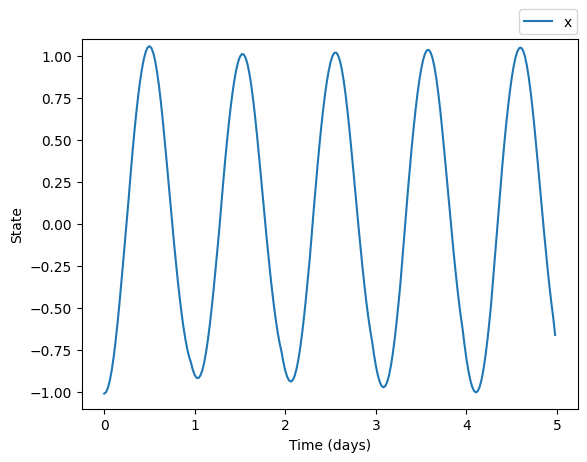

In [ ]:
plt.plot(time/24.0, trajectory.states[:,0], label='x')
plt.xlabel('Time (days)')
plt.ylabel('State')
plt.legend(loc='upper center', bbox_to_anchor=(0.94, 1.1), ncol=2) #| hide_line
plt.ylim([-1.1, 1.1]) #| hide_line
plt.show()

## Custom parameters and initial conditions

In the example above, we are not defining initial conditions nor parameters. This is because each model in the library has a default set of parameters and initial conditions. Initial conditions and parameters used in the simulation can be accessed by

In [ ]:
model.initial_condition

array([-1.00982605,  0.00125715,  0.        ])

In [ ]:
model.parameters

{'taux': 24.2,
 'mu': 0.23,
 'G': 33.75,
 'alpha_0': 0.05,
 'beta': 0.0075,
 'p': 0.5,
 'I0': 9500.0,
 'k': 0.55,
 'cbt_to_dlmo': 7.0}

We can run simulations with custom parameters and initial conditions by

In [ ]:
simulation_days = 5
dt = 0.5 # hours
time = np.arange(0, 24 * simulation_days, dt)

light_schedule = LightSchedule.Regular()
light_input = light_schedule(time)

custom_parameters = {
    'taux': 14.0, 'mu': 0.3, 'G': 34.0, 'alpha_0': 0.07,
    'delta': 0.0095, 'p': 0.7, 'I0': 9300.0, 'kparam': 0.75,
    'cbt_to_dlmo': 7.0}
custom_initial_condition = np.array([0.5, 0.1, 0.1])

model = Forger99(custom_parameters)
trajectory = model(time, custom_initial_condition, light_input)

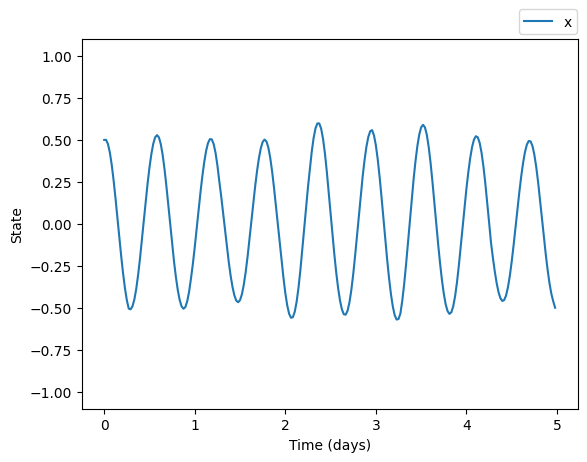

In [ ]:
plt.plot(time/24.0, trajectory.states[:,0], label='x')
plt.xlabel('Time (days)')
plt.ylabel('State')
plt.legend(loc='upper center', bbox_to_anchor=(0.94, 1.1), ncol=2) #| hide_line
plt.ylim([-1.1, 1.1]) #| hide_line
plt.show()

When defining custom parameters we can specify only a subset and the rest will maintain their default values (or any previously defined values).

In [ ]:
simulation_days = 5
dt = 0.5 # hours
time = np.arange(0, 24 * simulation_days, dt)

light_schedule = LightSchedule.Regular()
light_input = light_schedule(time)

model = Forger99({'taux': 48.0})
trajectory = model(time,  input=light_input)

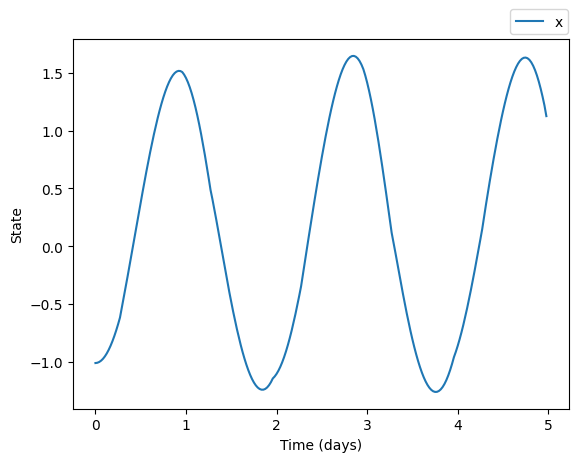

In [ ]:
#| echo: false
plt.plot(time/24.0, trajectory.states[:,0], label='x')
plt.xlabel('Time (days)')
plt.ylabel('State')
plt.legend(loc='upper center', bbox_to_anchor=(0.94, 1.1), ncol=2) #| hide_line
plt.show()

## Simulating from multiple initial conditions

Models accept arrays of initial conditions allowing to simulate from multiple initial conditions at once. For example, to simulate the Forger99 model from 100 different initial conditions we can do

In [ ]:
simulation_days = 10
dt = 0.5 # hours
time = np.arange(0, 24 * simulation_days, dt)

light_schedule = LightSchedule.Regular()
light_input = light_schedule(time)

x_values = np.linspace(-1.0, 1.0, 10)
xc_values = np.linspace(-1.0, 1.0, 10)
x_xc_stack = np.dstack(np.meshgrid(x_values, xc_values)).reshape(-1, 2)
multiple_initial_conditions = np.hstack((x_xc_stack, np.zeros((x_xc_stack.shape[0], 1))))
multiple_initial_conditions = multiple_initial_conditions.T

model = Forger99()
trajectory = model(time, multiple_initial_conditions, light_input)

Note that we have to format the initial conditions as a numpy array of dimensions (3, n) where n is the total number of initial conditions and 3 is the number of states in the model.

The resulting trajectory contains all the solutions in the same order as the initial conditions

In [ ]:
trajectory.states.shape

(480, 3, 100)

We can plot the solution for each initial condition by

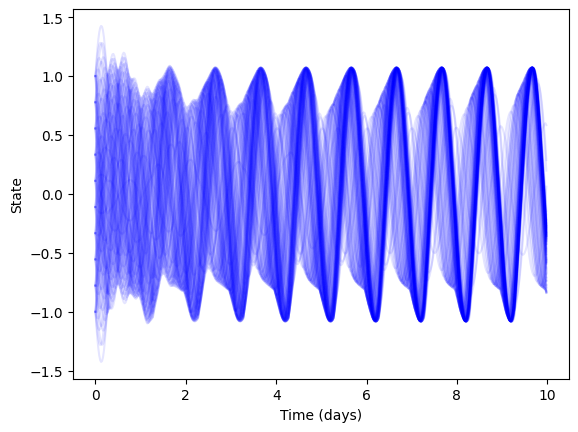

In [ ]:
for idx in range(trajectory.states.shape[2]):
    plt.plot(time/24.0, trajectory.states[:,0,idx], 
             color='b', alpha=0.1)
plt.xlabel('Time (days)')
plt.ylabel('State')
plt.show()

This is the recommended method to simulate multiple initial conditions--by passing a numpy array to the model. Our implementation takes advantage of numpy's vectorization to speed up the calculation. If we simulate each initial condition individually, the simulation will be slower.

## Estimation of circadian phase markers

Models support the estimation of Dim Light Melatonin Onset (DLMO) and Core Body Temperature Minimum (CBTmin) directly from the solution

In [ ]:
simulation_days = 5
dt = 0.5 # hours
time = np.arange(0, 24 * simulation_days, dt)

light_schedule = LightSchedule.Regular()
light_input = light_schedule(time)

model = Forger99()
trajectory = model(time, input=light_input)

cbt_times = model.cbt()
dlmo_times = model.dlmos()

In [ ]:
#| hide
import matplotlib.lines as lines

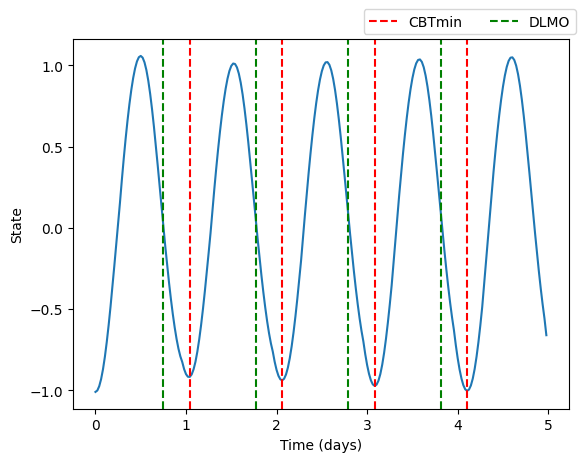

In [ ]:
#| echo: false
plt.plot(time/24.0, trajectory.states[:,0], label='x')
for cbt_time in cbt_times:
    plt.axvline(x=cbt_time/24.0, color='r', linestyle='--')
for dlmo_time in dlmo_times:
    plt.axvline(x=dlmo_time/24.0, color='g', linestyle='--')
plt.xlabel('Time (days)')
plt.ylabel('State')
cbt_line = lines.Line2D([], [], color='red', linestyle='--', label='CBTmin')
dlmo_line = lines.Line2D([], [], color='green', linestyle='--', label='DLMO')
plt.legend(handles=[cbt_line, dlmo_line], loc='upper center', bbox_to_anchor=(0.8, 1.1), ncol=2)
plt.show()

## Amplitude and phase calculation

Models also support the calculation of amplitude and phase at any desired timepoint

In [ ]:
simulation_days = 5
dt = 0.5 # hours
time = np.arange(0, 24 * simulation_days, dt)

light_schedule = LightSchedule.Regular()
light_input = light_schedule(time)

model = Forger99()
trajectory = model(time, input=light_input)

t_final = time[-1]
final_phase = model.phase(time=t_final)
final_amplitude = model.amplitude(time=t_final)
print("Final phase: {}".format(final_phase)) #| hide_line
print("Final amplitude: {}".format(final_amplitude)) #| hide_line

Final phase: 2.292056531980468
Final amplitude: 1.0007522907788031


# Implemented models

## Forger99

The `Forger99` model is taken from [Forger, Jewett, and Kronauer's 1999 article](https://doi.org/10.1177/074873099129000867) which defines a simplification of previous iterations of the van der Pol based oscillator models published in the 1990s. It is one of the most popular models in the circadian literature. The implementation in this package uses the parameters taken from [Serkh and Forger 2014](https://doi.org/10.1371/journal.pcbi.1003523) rather than the parameters from the original paper.

The model states are defined by three dynamic variables: $x$, $x_c$, and $n$. These states are related to circadian rhythms by defining the core body temperature minimum (a biomarker for circadian state) to be the minimum of the $x$ variable.

The differential equations governing the evolution of the `Forger99` model are:

$\frac{dx}{dt} = \frac{\pi}{12}(x_c + B)$

$\frac{dx_c}{dt} = \frac{\pi}{12}\left\{\mu \left( x_c - \frac{4x_{c}^3}{3} \right) - x \left[ \left( \frac{24}{0.99669 \tau_x} \right)^2 + kB \right] \right\}$

$\frac{dn}{dt} = 60[\alpha(I)(1-n)-\beta n]$

where

$\alpha(I) = \alpha_0\left( \frac{I^p}{I_0^p}\right)$

$B = G(1-n)\alpha(I)(1-0.4x)(1-0.4x_c)$

The default parameters for this model are:

In [ ]:
model = Forger99()
model.parameters

{'taux': 24.2,
 'mu': 0.23,
 'G': 33.75,
 'alpha_0': 0.05,
 'beta': 0.0075,
 'p': 0.5,
 'I0': 9500.0,
 'k': 0.55,
 'cbt_to_dlmo': 7.0}

The `cbt_to_dlmo` parameter is used to convert the core body temperature minimum to DLMO. The default behavior is DLMO ocurring 7 hours before CBTmin.

## Jewett99

The `Jewett99` model is taken from [Jewett, Forger, and Kronauer's 1999 article](https://doi.org/10.1177/074873049901400608) which defines several refinements to a van der Pol oscillator model developed by Kronauer previously. One of the main features of this model are the high-order terms in the differential equations which allow for a more accurate representation of the circadian system than previous models.

Similarly to `Forger99` the model states are defined by three dynamic variables: $x$, $x_c$, and $n$. The variable $x$ is related to the core body temperature and $n$ to the processed light input.

The differential equations governing the evolution of the `Jewett99` model are:

$\frac{dx}{dt} = \frac{\pi}{12} \left[x_c + \mu \left(\frac{x}{3} + \frac{4x^3}{3} - \frac{256 x^7}{105}\right) + B\right]$

$\frac{dx_c}{dt} = \frac{\pi}{12} \left\{ q B x_c - \left[ \left( \frac{24}{0.99729 \tau_{x}} \right)^2 + k B \right] x \right\}$

$\frac{dn}{dt} = 60[\alpha(I)(1-n)-\beta n]$

where

$\alpha(I) = \alpha_0\left( \frac{I^p}{I_0^p}\right)$

$B = G(1-n)\alpha(I)(1-0.4x)(1-0.4x_c)$

The default parameters for this model are:

In [ ]:
model = Jewett99()
model.parameters

{'taux': 24.2,
 'mu': 0.13,
 'G': 19.875,
 'beta': 0.013,
 'k': 0.55,
 'q': 0.3333333333333333,
 'I0': 9500,
 'p': 0.6,
 'alpha_0': 0.16,
 'phi_ref': 0.8,
 'cbt_to_dlmo': 7.0}

The `cbt_to_dlmo` and `phi_ref` parameters are used to calculate the core body temperature minimum and convert it to DLMO. The CBTmin is calculated as the minimum of the $x$ variable plus a shift of $\phi_{\text{ref}}=0.8$ hours. The DLMO is calculated as CBTmin minus 7.0 hours.

## Hannay19

The `Hannay19` model is taken from [Hannay, Booth, and Forger's 2019 article](https://doi.org/10.1177/0748730419878298). This model isn't based on a van der Pol oscillator and instead it is systematically derived from a high-dimensional model for each clock neuron using the $m^2$ ansatz ([Hannay et al. 2018](https://doi.org/10.1126/sciadv.1701047)). The `Hannay19` implementation corresponds to the single population model within the article.

The model describes the circadian state using polar coordinates and features a slight modification fo the light processing function found in van der Pol type models. Thus, the model states are defined by: $R$, $\psi$, and $n$.

The differential equations governing the evolution of the `Hannay19` model are:

$\frac{dR}{dt} = - (D + \gamma)R + \frac{K}{2}cos(\beta)R(1-R^4) + L_R(R, \psi)$

$\frac{d\psi}{dt} = \omega_0 + \frac{K}{2}sin(\beta)(1+R^4) + L_{\psi}(R,\psi)$

$\frac{dn}{dt} = 60\left[\alpha(I)(1-n)-\delta n \right]$

where

$L_R(R,\psi) = \frac{A_1}{2}B(t)(1-R^4)cos(\psi + \beta_{L1}) + \frac{A_2}{2}B(t)R(1-R^8)cos(2\psi + \beta_{L2})$

$L_{\psi}(R, \psi) = \sigma B(t) - \frac{A_1}{2}B(t)\left(\frac{1}{R} + R^3 \right)\sin(\psi + \beta_{L1}) - \frac{A_2}{2}B(t)(1+R^8)\sin(2\psi + \beta_{L2})$

$\alpha(I) = \frac{\alpha_0 I^p}{I^p + I_0}$

$B(t) = G(1-n)\alpha(L)$

The default parameters for this model are:

In [ ]:
model = Hannay19()
model.parameters

{'tau': 23.84,
 'K': 0.06358,
 'gamma': 0.024,
 'Beta1': -0.09318,
 'A1': 0.3855,
 'A2': 0.1977,
 'BetaL1': -0.0026,
 'BetaL2': -0.957756,
 'sigma': 0.0400692,
 'G': 33.75,
 'alpha_0': 0.05,
 'delta': 0.0075,
 'p': 1.5,
 'I0': 9325.0,
 'cbt_to_dlmo': 7.0}

The `cbt_to_dlmo` parameter is used to convert the core body temperature minimum to DLMO. The default behavior is DLMO ocurring 7 hours before CBTmin.

## Hannay19TP

The `Hannay19TP` model comes from the same article as `Hannay19` but stems from two populations of clock neurons rather than one. These two populations are the dorsal and ventral ones which define the model states to be: $R_v$, $R_d$, $\psi_v$, $\psi_d$, and $n$.

The differential equations governing the evolution of the `Hannay19TP` model are:

$\frac{dR_v}{dt} = -\gamma R_v + \frac{K_{vv}}{2} R_v (1 - R_{v}^4) + \frac{K_{dv}}{2}R_d (1 - R_{v}^4)\cos(\psi_d - \psi_v) + L_R(R_v, \psi_v)$

$\frac{dR_d}{dt} = -\gamma R_d + \frac{K_{dd}}{2} R_d (1 - R_{d}^4) + \frac{K_{vd}}{2} R_v (1 - R_{d}^4)\cos(\psi_d - \psi_v)$

$\frac{d\psi_v}{dt} = \omega_v + \frac{K_{dv}}{2} R_d \left( \frac{1}{R_v} + R_{v}^3\right)\sin(\psi_d - \psi_v) + L_\psi(R_v, \psi_v)$

$\frac{d\psi_d}{dt} = \omega_d - \frac{K_{vd}}{2} R_v \left( \frac{1}{R_d} + R_{d}^3\right)\sin(\psi_d - \psi_v)$

$\frac{dn}{dt} = 60\left[\alpha(I)(1-n)-\delta n \right]$

where

$L_R(R_v,\psi_v) = \frac{A_1}{2}B(t)(1-R_v^4)cos(\psi_v + \beta_{L1}) + \frac{A_2}{2}B(t)R_v(1-R_v^8)cos(2\psi_v + \beta_{L2})$

$L_{\psi}(R_v, \psi_v) = \sigma B(t) - \frac{A_1}{2}B(t)\left(\frac{1}{R_v} + R_v^3 \right)\sin(\psi_v + \beta_{L1}) - \frac{A_2}{2}B(t)(1+R_v^8)\sin(2\psi_v + \beta_{L2})$

$\alpha(I) = \frac{\alpha_0 I^p}{I^p + I_0}$

$B(t) = G(1-n)\alpha(L)$

The default parameters for this model are:

In [ ]:
model = Hannay19TP()
model.parameters

{'tauV': 24.25,
 'tauD': 24.0,
 'Kvv': 0.05,
 'Kdd': 0.04,
 'Kvd': 0.05,
 'Kdv': 0.01,
 'gamma': 0.024,
 'A1': 0.440068,
 'A2': 0.159136,
 'BetaL': 0.06452,
 'BetaL2': -1.38935,
 'sigma': 0.0477375,
 'G': 33.75,
 'alpha_0': 0.05,
 'delta': 0.0075,
 'p': 1.5,
 'I0': 9325.0,
 'cbt_to_dlmo': 7.0}

The `cbt_to_dlmo` parameter is used to convert the core body temperature minimum to DLMO. The default behavior is DLMO ocurring 7 hours before CBTmin.

# API Documentation

In [ ]:
show_doc(DynamicalTrajectory)

---

[source](https://github.com/Arcascope/circadian/blob/main/circadian/models.py#L42){target="_blank" style="float:right; font-size:smaller"}

### DynamicalTrajectory

>      DynamicalTrajectory (time:numpy.ndarray, states:numpy.ndarray)

A class to store solutions of differential equation models that contains both the time points and the states

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| time | ndarray | time points |
| states | ndarray | state at time points |
| **Returns** | **None** |  |

In [ ]:
show_doc(DynamicalTrajectory.__call__)

---

[source](https://github.com/Arcascope/circadian/blob/main/circadian/models.py#L62){target="_blank" style="float:right; font-size:smaller"}

### DynamicalTrajectory.__call__

>      DynamicalTrajectory.__call__ (timepoint:float)

Return the state at time t, linearly interpolated

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| timepoint | float |  |
| **Returns** | **ndarray** | **state of the system** |

In [ ]:
show_doc(DynamicalTrajectory.get_batch)

---

[source](https://github.com/Arcascope/circadian/blob/main/circadian/models.py#L101){target="_blank" style="float:right; font-size:smaller"}

### DynamicalTrajectory.get_batch

>      DynamicalTrajectory.get_batch (batch_idx:int)

Obtain the trajectory for a single batch

In [ ]:
show_doc(CircadianModel)

---

[source](https://github.com/Arcascope/circadian/blob/main/circadian/models.py#L198){target="_blank" style="float:right; font-size:smaller"}

### CircadianModel

>      CircadianModel (default_params:dict, num_states:int, num_inputs:int,
>                      default_initial_condition:numpy.ndarray)

Abstract base class for circadian models that defines the common interface for all implementations

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| default_params | dict | default parameters for the model |
| num_states | int | number of independent variables in the model |
| num_inputs | int | number of inputs to the model such as light or wake state |
| default_initial_condition | ndarray | default initial conditions for the model |
| **Returns** | **None** |  |

In [ ]:
show_doc(CircadianModel.step_rk4)

---

[source](https://github.com/Arcascope/circadian/blob/main/circadian/models.py#L291){target="_blank" style="float:right; font-size:smaller"}

### CircadianModel.step_rk4

>      CircadianModel.step_rk4 (state:numpy.ndarray, input:numpy.ndarray,
>                               dt:float)

Integrate the state of the model for one timestep using a fourth-order Runge-Kutta algorithm. Assumes a constant light value for the time step

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| state | ndarray | dynamical state of the model |
| input | ndarray | inputs to the model such as light or wake state |
| dt | float | step size in hours |
| **Returns** | **ndarray** |  |

In [ ]:
show_doc(CircadianModel.integrate)

---

[source](https://github.com/Arcascope/circadian/blob/main/circadian/models.py#L306){target="_blank" style="float:right; font-size:smaller"}

### CircadianModel.integrate

>      CircadianModel.integrate (time:numpy.ndarray,
>                                initial_condition:numpy.ndarray=None,
>                                input:numpy.ndarray=None)

Solve the model for specific timepoints given initial conditions and model inputs

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| time | ndarray |  | time points for integration. Time difference between consecutive values determines step size of the solver |
| initial_condition | ndarray | None | initial state of the model |
| input | ndarray | None | model input (such as light or wake) for each time point |
| **Returns** | **DynamicalTrajectory** |  |  |

In [ ]:
show_doc(CircadianModel.__call__)

---

[source](https://github.com/Arcascope/circadian/blob/main/circadian/models.py#L341){target="_blank" style="float:right; font-size:smaller"}

### CircadianModel.__call__

>      CircadianModel.__call__ (time:numpy.ndarray,
>                               initial_condition:numpy.ndarray=None,
>                               input:numpy.ndarray=None)

Wrapper to integrate

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| time | ndarray |  | time points for integration. Time difference between each consecutive pair of values determines step size of the solver |
| initial_condition | ndarray | None | initial state of the model |
| input | ndarray | None | model input (such as light or wake) for each time point |

In [ ]:
show_doc(CircadianModel.get_parameters_array)

---

[source](https://github.com/Arcascope/circadian/blob/main/circadian/models.py#L351){target="_blank" style="float:right; font-size:smaller"}

### CircadianModel.get_parameters_array

>      CircadianModel.get_parameters_array ()

Returns the parameters for the model as a numpy array

In [ ]:
show_doc(CircadianModel.equilibrate)

---

[source](https://github.com/Arcascope/circadian/blob/main/circadian/models.py#L388){target="_blank" style="float:right; font-size:smaller"}

### CircadianModel.equilibrate

>      CircadianModel.equilibrate (time:numpy.ndarray, input:numpy.ndarray,
>                                  num_loops:int=10)

Equilibrate the model by looping the given light_estimate. Assumes the schedule repeats periodically after it ends

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| time | ndarray |  | time points for integration. Time difference between each consecutive pair of values determines step size of the solver |
| input | ndarray |  | model input (such as light or wake) for each time point |
| num_loops | int | 10 | number of times to loop the input |
| **Returns** | **ndarray** |  | **final state of the model** |

In [ ]:
show_doc(CircadianModel.amplitude)

---

[source](https://github.com/Arcascope/circadian/blob/main/circadian/models.py#L372){target="_blank" style="float:right; font-size:smaller"}

### CircadianModel.amplitude

>      CircadianModel.amplitude (time:float)

Calculates the amplitude of the model at a given timepoint

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| time | float | timepoint to calculate the amplitude at |
| **Returns** | **float** |  |

In [ ]:
show_doc(CircadianModel.phase)

---

[source](https://github.com/Arcascope/circadian/blob/main/circadian/models.py#L380){target="_blank" style="float:right; font-size:smaller"}

### CircadianModel.phase

>      CircadianModel.phase (trajectory:__main__.DynamicalTrajectory,
>                            time:float=None)

Calculates the phase of the model at a given timepoint

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| trajectory | DynamicalTrajectory |  |  |
| time | float | None | timepoint to calculate the phase at. If None, the phase is calculated for the entire trajectory |
| **Returns** | **float** |  |  |

In [ ]:
show_doc(CircadianModel.cbt)

---

[source](https://github.com/Arcascope/circadian/blob/main/circadian/models.py#L366){target="_blank" style="float:right; font-size:smaller"}

### CircadianModel.cbt

>      CircadianModel.cbt ()

Finds the core body temperature minumum markers along a trajectory

In [ ]:
show_doc(CircadianModel.dlmos)

---

[source](https://github.com/Arcascope/circadian/blob/main/circadian/models.py#L360){target="_blank" style="float:right; font-size:smaller"}

### CircadianModel.dlmos

>      CircadianModel.dlmos ()

Finds the Dim Light Melatonin Onset (DLMO) markers along a trajectory

In [ ]:
show_doc(Forger99)

---

[source](https://github.com/Arcascope/circadian/blob/main/circadian/models.py#LNone){target="_blank" style="float:right; font-size:smaller"}

### Forger99

>      Forger99 (params=None)

Implementation of Forger's 1999 model from the article 'A simpler model of the human circadian pacemaker'

In [ ]:
show_doc(Jewett99)

---

[source](https://github.com/Arcascope/circadian/blob/main/circadian/models.py#LNone){target="_blank" style="float:right; font-size:smaller"}

### Jewett99

>      Jewett99 (params=None)

Implementation of Jewett's 1999 model from the article 'Revised Limit Cycle Oscillator Model of Human Circadian Pacemaker'

In [ ]:
show_doc(Hannay19)

---

[source](https://github.com/Arcascope/circadian/blob/main/circadian/models.py#LNone){target="_blank" style="float:right; font-size:smaller"}

### Hannay19

>      Hannay19 (params=None)

Implementation of Hannay's 2019 single population model from the article 'Macroscopic models for human circadian rhythms'

In [ ]:
show_doc(Hannay19TP)

---

[source](https://github.com/Arcascope/circadian/blob/main/circadian/models.py#LNone){target="_blank" style="float:right; font-size:smaller"}

### Hannay19TP

>      Hannay19TP (params=None)

Implementation of Hannay's 2019 two population model from the article 'Macroscopic models for human circadian rhythms'

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()